In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm
import yaml

from scipy.stats import binned_statistic_2d
# import shap

from flash_ansr import get_path, ExpressionSpace
from flash_ansr.eval.utils import bootstrapped_metric_ci

In [2]:
def nan_false_statistic(X, statistic):
    X_copy = np.array(X)
    # Where X is nan, replace with False
    X_copy[np.isnan(X_copy)] = False
    return statistic(X_copy)

In [3]:
MODELS = [os.path.join('analysis_points_v7.0', m) for m in os.listdir(get_path('results', 'evaluation', 'analysis_points_v7.0'))]

In [4]:
MODELS_DESCRIPTION = {k: k.replace('v7.0_', '') for k in MODELS}

In [5]:
TEST_SETS = ['train', 'val', 'feynman', 'soose_nc', 'nguyen', 'pool_15']
TEST_SET_TITLES = {
    'train': 'Train',
    'val': 'Val',
    'feynman': 'Feynman',
    'soose_nc': 'S.-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool 15',
}

In [6]:
configs = {}

for model in MODELS:
    with open(get_path(f'configs/{model}/evaluation.yaml'), 'r') as f:
        configs[model] = yaml.safe_load(f)

In [7]:
test_sets = {model: [path.replace('.pickle', '') for path in os.listdir(get_path(f'results/evaluation/{model}'))] for model in MODELS}

for model, model_test_sets in test_sets.items():
    # Reorder the test sets as follows: train, val, feynman, soose_nc, nguyen
    for i, s in enumerate(TEST_SETS):
        if s in model_test_sets:
            model_test_sets.remove(s)
            model_test_sets.insert(i, s)

In [8]:
results = {}

for model, model_test_sets in test_sets.items():
    results[model] = {test_set: {'path': get_path(f'results/evaluation/{model}/{test_set}.pickle')} for test_set in model_test_sets}

In [9]:
remove_invalid = []

for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items(), desc=f'Loading {model} results'):
        with open(test_set_results['path'], 'rb') as f:
            test_set_results['data'] = pickle.load(f)

            columns_to_rename = set()
            for k, v in test_set_results['data'].items():
                try:
                    test_set_results['data'][k] = np.array(v)
                except ValueError:
                    pass

                if '_free_' in k:
                    columns_to_rename.add(k)

            for k in columns_to_rename:
                test_set_results['data'][k.replace('_free_', '_')] = test_set_results['data'][k]
                del test_set_results['data'][k]

            # keys_to_remove = [k for k in test_set_results['data'].keys() if 'residuals' in k]
            # keys_to_remove.extend(['x', 'y'])

            # for k in keys_to_remove:
            #     del test_set_results['data'][k]

Loading analysis_points_v7.0/v7.0_128-points results: 100%|██████████| 4/4 [00:16<00:00,  4.08s/it]
Loading analysis_points_v7.0/v7.0_64-points results: 100%|██████████| 4/4 [00:16<00:00,  4.08s/it]
Loading analysis_points_v7.0/v7.0_1-points results: 100%|██████████| 4/4 [00:16<00:00,  4.21s/it]
Loading analysis_points_v7.0/v7.0_512-points results: 100%|██████████| 4/4 [00:17<00:00,  4.44s/it]
Loading analysis_points_v7.0/v7.0_4-points results: 100%|██████████| 4/4 [00:16<00:00,  4.20s/it]
Loading analysis_points_v7.0/v7.0_8-points results: 100%|██████████| 4/4 [00:18<00:00,  4.65s/it]
Loading analysis_points_v7.0/v7.0_32-points results: 100%|██████████| 4/4 [00:17<00:00,  4.48s/it]
Loading analysis_points_v7.0/v7.0_16-points results: 100%|██████████| 4/4 [00:18<00:00,  4.56s/it]
Loading analysis_points_v7.0/v7.0_256-points results: 100%|██████████| 4/4 [00:17<00:00,  4.42s/it]
Loading analysis_points_v7.0/v7.0_2-points results: 100%|██████████| 4/4 [00:16<00:00,  4.12s/it]


In [10]:
for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items(), desc=f'Filtering {model} results'):
        for k in test_set_results['data'].keys():
            test_set_results['data'][k] = test_set_results['data'][k][1:]

Filtering analysis_points_v7.0/v7.0_128-points results: 100%|██████████| 4/4 [00:00<00:00, 637.07it/s]
Filtering analysis_points_v7.0/v7.0_64-points results: 100%|██████████| 4/4 [00:00<00:00, 636.22it/s]
Filtering analysis_points_v7.0/v7.0_1-points results: 100%|██████████| 4/4 [00:00<00:00, 866.82it/s]
Filtering analysis_points_v7.0/v7.0_512-points results: 100%|██████████| 4/4 [00:00<00:00, 663.92it/s]
Filtering analysis_points_v7.0/v7.0_4-points results: 100%|██████████| 4/4 [00:00<00:00, 710.27it/s]
Filtering analysis_points_v7.0/v7.0_8-points results: 100%|██████████| 4/4 [00:00<00:00, 712.62it/s]
Filtering analysis_points_v7.0/v7.0_32-points results: 100%|██████████| 4/4 [00:00<00:00, 705.34it/s]
Filtering analysis_points_v7.0/v7.0_16-points results: 100%|██████████| 4/4 [00:00<00:00, 809.20it/s]
Filtering analysis_points_v7.0/v7.0_256-points results: 100%|██████████| 4/4 [00:00<00:00, 769.84it/s]
Filtering analysis_points_v7.0/v7.0_2-points results: 100%|██████████| 4/4 [00:00<

In [11]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    n_restarts = configs[model].get('n_restarts', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        if model == 'pysr':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time'] * 32  # 32 cores
        
        elif model == 'nesymres-100M':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time']

        else:
            results[model][test_set]['data']['wall_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))
            results[model][test_set]['data']['sys_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))

100%|██████████| 4/4 [00:00<00:00, 11530.73it/s]


In [12]:
# Replace 'beam_val_' with 'val_beam' in columns where 'beam_val_' is present
for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        columns_before = set(data.keys())
        changed_columns = []
        for k in columns_before:
            if 'beam_val_' in k:
                data[k.replace('beam_val_', 'val_beam_')] = data[k]
                changed_columns.append(k)

        for k in changed_columns:
            del data[k]

100%|██████████| 4/4 [00:00<00:00, 8890.95it/s]


In [13]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        results[model][test_set]['data']['length_target'] = np.array([len(data['input_ids'][i]) for i in range(len(data['input_ids']))])
        
        for j in range(beam_width):
            results[model][test_set]['data'][f'length_beam_{j + 1}'] = np.array([len(data[f'free_beam_{j + 1}'][i]) for i in range(len(data[f'free_beam_{j + 1}']))])

            if f'residuals_beam_{j + 1}' not in data:
                continue
            results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
        
        if '_beam_1' not in data:
            continue

        max_length = max(max([len(beam) for beam in data[f'_beam_{j + 1}']]) for j in range(beam_width))

        for j in range(beam_width):
            padded_beam = [beam + [0] * (max_length - len(beam)) for beam in data[f'_beam_{j + 1}']]
            data[f'_beam_{j + 1}'] = np.array(padded_beam)

  0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_9666/343701655.py:14: RuntimeWarning: All-NaN slice encountered
  results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
100%|██████████| 4/4 [00:00<00:00, 11.15it/s]


In [14]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    for test_set, test_set_results in tqdm(model_results.items()):
        valid = True
        data = test_set_results['data']

        beam_columns = [k.replace('_beam_1', '') for k in data.keys() if k.endswith(f'beam_1') and not 'residuals' in k and not 'free' in k]

        # Create new columns with metrics of the best beam (by mse_{generation_type}_beam_{i}) and store it as {metric}_{generation_type}_best_beam
        # Create new columns
        for column in beam_columns:
            if isinstance(data[column + '_beam_1'][0], np.ndarray):
                data[column + '_best_beam'] = np.nan * np.ones_like(data[column + '_beam_1'])
            else:
                data[column + '_best_beam'] = np.nan * np.ones(len(data[column + '_beam_1']))

        data['best_beam'] = np.nan * np.ones(len(data['mse_beam_1']))

        # For each instance, find the best beam by mse
        for i in range(len(data['mse_beam_1'])):
            mse_list = np.array([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()])
            if np.all(np.isnan(mse_list)):
                continue
            best_beam = np.nanargmin([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()]) + 1
            data['best_beam'][i] = best_beam
            for column in beam_columns:
                data[column + '_best_beam'][i] = data[column + f'_beam_{best_beam}'][i]

100%|██████████| 4/4 [00:00<00:00, 26.41it/s]


In [15]:
# Design features
for model, model_results in results.items():
    for test_set, test_set_results in model_results.items():
        print(f'Processing {model} {test_set}')
        for maybe_val in ['', '_val']:
            test_set_results['data'][f'is_finite{maybe_val}'] = np.array([np.isfinite(r2) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'FVU-eps_accuracy{maybe_val}'] = np.array([(1 - r2) <= np.finfo(np.float32).eps for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu{maybe_val}'] = np.array([1 - r2 for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])
            test_set_results['data'][f'log_fvu{maybe_val}'] = np.array([np.log10(1 - r2 + np.finfo(np.float32).eps) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'] = np.copy(test_set_results['data'][f'fvu{maybe_val}'])
            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'][test_set_results['data'][f'FVU-eps_accuracy{maybe_val}']] = np.nan

            test_set_results['data'][f'log_fvu_not_epsilon{maybe_val}'] = np.array([np.log10(fvu) for fvu in test_set_results['data'][f'fvu_not_epsilon{maybe_val}']])

        if 'perplexity' in test_set_results['data']:
            test_set_results['data']['log_ppl'] = [np.log10(ppl) for ppl in test_set_results['data']['perplexity']]
        else:
            test_set_results['data']['log_ppl'] = [np.nan] * len(test_set_results['data']['r2_best_beam'])

Processing analysis_points_v7.0/v7.0_128-points feynman
Processing analysis_points_v7.0/v7.0_128-points soose_nc
Processing analysis_points_v7.0/v7.0_128-points nguyen
Processing analysis_points_v7.0/v7.0_128-points pool_15
Processing analysis_points_v7.0/v7.0_64-points feynman
Processing analysis_points_v7.0/v7.0_64-points soose_nc
Processing analysis_points_v7.0/v7.0_64-points nguyen
Processing analysis_points_v7.0/v7.0_64-points pool_15
Processing analysis_points_v7.0/v7.0_1-points feynman
Processing analysis_points_v7.0/v7.0_1-points soose_nc
Processing analysis_points_v7.0/v7.0_1-points nguyen
Processing analysis_points_v7.0/v7.0_1-points pool_15
Processing analysis_points_v7.0/v7.0_512-points feynman
Processing analysis_points_v7.0/v7.0_512-points soose_nc
Processing analysis_points_v7.0/v7.0_512-points nguyen
Processing analysis_points_v7.0/v7.0_512-points pool_15
Processing analysis_points_v7.0/v7.0_4-points feynman
Processing analysis_points_v7.0/v7.0_4-points soose_nc
Process

In [16]:
# Find the intersection of the columns of all the dataframes
compare_columns = set.union(*[set(test_set_results['data'].keys()) for model_results in results.values() for test_set_results in model_results.values()])
compare_columns = compare_columns - {'x', 'y', 'y_noisy', 'x_val', 'y_val', 'y_noisy_val', 'constants', 'input_ids', 'labels', 'residuals_beam_1', 'n_support', 'free_best_beam'}
compare_columns = compare_columns - {c for c in compare_columns if any(c.endswith(f'_{i}') or 'free' in c for i in range(1, 1024))}
# compare_columns = compare_columns.union({'perplexity', 'precision_best_beam', 'recall_best_beam', 'meteor_best_beam', 'edit_distance'})
compare_columns

{'FVU-eps_accuracy',
 'FVU-eps_accuracy_val',
 'L_inf_best_beam',
 'NSRTS_accuracy_close_best_beam',
 'NSRTS_accuracy_close_val_best_beam',
 'NSRTS_accuracy_r2_best_beam',
 'NSRTS_accuracy_r2_val_best_beam',
 'accuracy_best_beam',
 'beam_search_time',
 'best_beam',
 'bleu_best_beam',
 'edit_distance_best_beam',
 'f1_score_best_beam',
 'fvu',
 'fvu_not_epsilon',
 'fvu_not_epsilon_val',
 'fvu_val',
 'is_finite',
 'is_finite_val',
 'length_best_beam',
 'length_target',
 'log_fvu',
 'log_fvu_not_epsilon',
 'log_fvu_not_epsilon_val',
 'log_fvu_val',
 'log_ppl',
 'meteor_best_beam',
 'mse_best_beam',
 'mse_val_best_beam',
 'perplexity',
 'precision_best_beam',
 'r2_best_beam',
 'r2_val_best_beam',
 'recall_best_beam',
 'reciprocal_rank',
 'refiner_time_best_beam',
 'rouge1_fmeasure_best_beam',
 'rouge1_precision_best_beam',
 'rouge1_recall_best_beam',
 'rouge2_fmeasure_best_beam',
 'rouge2_precision_best_beam',
 'rouge2_recall_best_beam',
 'rougeL_fmeasure_best_beam',
 'rougeL_precision_best

In [17]:
array_dfs = {
    model: {
        test_set:
        pd.DataFrame({k: v for k, v in test_set_results['data'].items() if k in compare_columns}).astype(float)
            for test_set, test_set_results in model_results.items()}
            for model, model_results in results.items()}

In [18]:
compare_columns_defaults = {
    'FVU-eps_accuracy': 0,
    'perplexity': np.inf,
    'log_ppl': np.inf,
    'precision_best_beam': 0,
    'recall_best_beam': 0,
    'L_inf_best_beam': np.inf,
    'NSRTS_accuracy_close_best_beam': 0,
    'NSRTS_accuracy_r2_best_beam': 0,
    'NSRTS_accuracy_close_val_best_beam': 0,
    'NSRTS_accuracy_r2_val_best_beam': 0,
    'accuracy_best_beam': 0,
    'bleu_best_beam': 0,
    'edit_distance_best_beam': np.inf,
    'f1_score_best_beam': 0,
    'fvu': np.inf,
    'log_fvu': np.inf,
    'fvu_not_epsilon': np.inf,
    'log_fvu_not_epsilon': np.inf,
    'log_ppl': np.inf,
    'meteor_best_beam': 0,
    'mse_best_beam': np.inf,
    'mse_val_best_beam': np.inf,
    'perplexity': np.inf,
    'precision_best_beam': 0,
    'r2_best_beam': -np.inf,
    'r2_val_best_beam': -np.inf,
    'recall_best_beam': 0,
    'reciprocal_rank': 0,
    'rouge1_fmeasure_best_beam': 0,
    'rouge1_precision_best_beam': 0,
    'rouge1_recall_best_beam': 0,
    'rouge2_fmeasure_best_beam': 0,
    'rouge2_precision_best_beam': 0,
    'rouge2_recall_best_beam': 0,
    'rougeL_fmeasure_best_beam': 0,
    'rougeL_precision_best_beam': 0,
    'rougeL_recall_best_beam': 0,
    'structural_accuracy_best_beam': 0,
    'tree_edit_distance_best_beam': np.inf,
    'wall_time': np.inf,
    'sys_time': np.inf,
    'is_finite': 0,
}

In [19]:
from functools import partial

In [20]:
def naninfmean(x):
    return np.nanmean(np.array(x)[np.isfinite(x)])

# Per Dataset

In [21]:
summaries = {model: {test_set: {column: {} for column in compare_columns} for test_set, df in model_dfs.items()} for model, model_dfs in array_dfs.items()}
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        for column in tqdm(compare_columns, desc=f'{model} {test_set}'):
            sub_metrics = ['mean', 'median', '2.5p', '97.5p']
            sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]
            if column in df.columns:
                data = df[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                summaries[model][test_set][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
            else:
                summaries[model][test_set][column] = {k: (np.nan, ) * 3 for k in sub_metrics}

            if metrics is None:
                metrics = summaries[model][test_set][column].keys()

analysis_points_v7.0/v7.0_128-points feynman:  18%|█▊        | 9/49 [00:00<00:03, 10.01it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_points_v7.0/v7.0_1-points feynman:  20%|██        | 10/49 [00:00<00:03, 10.38it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4623: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
analysis_points_v7.0/v7.0_1-points feynman:  98%|█████████▊| 48/49 [00:04<00:00, 10.26it/s]/tmp/ipykernel_9666/3880369273.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(x)[np.isfinite(x)])
analysis_points_v7.0/v7.0_2-points pool_15: 100%|██████████| 49/49 [00:05<00:00,  8.25it/s]


In [22]:
# Show a summary table for each metric
# In each table, the rows are the models and the columns are the test sets
# For columns with 'accuracy' in the name, show the mean. For other columns show the median.

summary_tables = {
    column: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    test_set: summaries[model][test_set][column][metric][k]
                    for test_set in summaries[model].keys()}
                    for model in summaries.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for column in compare_columns}

#### Validity

In [23]:
m = 'is_finite'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_points_v7.0/v7.0_128-points,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_points_v7.0/v7.0_64-points,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_points_v7.0/v7.0_1-points,"0.992 (0.986, 0.997)","0.995 (0.99, 0.999)","1.0 (1.0, 1.0)","0.951 (0.938, 0.964)"
analysis_points_v7.0/v7.0_512-points,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_points_v7.0/v7.0_4-points,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_points_v7.0/v7.0_8-points,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_points_v7.0/v7.0_32-points,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_points_v7.0/v7.0_16-points,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_points_v7.0/v7.0_256-points,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_points_v7.0/v7.0_2-points,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","0.995 (0.99, 0.999)"


#### Recovery Rate

In [24]:
m = 'NSRTS_accuracy_close_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_points_v7.0/v7.0_128-points,"0.903 (0.883, 0.919)","0.811 (0.786, 0.836)","0.875 (0.853, 0.895)","0.627 (0.597, 0.658)"
analysis_points_v7.0/v7.0_64-points,"0.896 (0.877, 0.914)","0.79 (0.766, 0.816)","0.875 (0.854, 0.895)","0.601 (0.568, 0.63)"
analysis_points_v7.0/v7.0_1-points,"0.987 (0.98, 0.994)","0.995 (0.991, 0.999)","0.999 (0.997, 1.0)","0.943 (0.928, 0.957)"
analysis_points_v7.0/v7.0_512-points,"0.882 (0.862, 0.902)","0.839 (0.815, 0.861)","0.868 (0.846, 0.888)","0.645 (0.614, 0.672)"
analysis_points_v7.0/v7.0_4-points,"0.767 (0.74, 0.791)","0.539 (0.51, 0.57)","0.637 (0.608, 0.666)","0.607 (0.576, 0.637)"
analysis_points_v7.0/v7.0_8-points,"0.818 (0.795, 0.84)","0.485 (0.452, 0.519)","0.645 (0.615, 0.674)","0.588 (0.559, 0.619)"
analysis_points_v7.0/v7.0_32-points,"0.882 (0.861, 0.902)","0.726 (0.7, 0.753)","0.856 (0.833, 0.877)","0.58 (0.549, 0.613)"
analysis_points_v7.0/v7.0_16-points,"0.849 (0.827, 0.871)","0.605 (0.574, 0.637)","0.788 (0.763, 0.814)","0.575 (0.544, 0.605)"
analysis_points_v7.0/v7.0_256-points,"0.895 (0.875, 0.913)","0.817 (0.794, 0.842)","0.859 (0.838, 0.88)","0.612 (0.582, 0.642)"
analysis_points_v7.0/v7.0_2-points,"0.972 (0.961, 0.982)","0.974 (0.964, 0.984)","0.961 (0.949, 0.973)","0.962 (0.949, 0.974)"


In [25]:
m = 'NSRTS_accuracy_r2_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_points_v7.0/v7.0_128-points,"0.959 (0.946, 0.971)","0.884 (0.863, 0.905)","0.99 (0.983, 0.996)","0.826 (0.8, 0.85)"
analysis_points_v7.0/v7.0_64-points,"0.973 (0.963, 0.982)","0.858 (0.836, 0.88)","0.988 (0.98, 0.994)","0.829 (0.804, 0.85)"
analysis_points_v7.0/v7.0_1-points,"0.982 (0.973, 0.989)","0.994 (0.989, 0.998)","0.993 (0.988, 0.998)","0.921 (0.904, 0.937)"
analysis_points_v7.0/v7.0_512-points,"0.937 (0.92, 0.952)","0.884 (0.865, 0.903)","0.99 (0.984, 0.995)","0.81 (0.785, 0.833)"
analysis_points_v7.0/v7.0_4-points,"0.94 (0.925, 0.955)","0.891 (0.869, 0.909)","0.923 (0.906, 0.939)","0.899 (0.879, 0.917)"
analysis_points_v7.0/v7.0_8-points,"0.956 (0.942, 0.968)","0.76 (0.733, 0.784)","0.813 (0.788, 0.836)","0.831 (0.807, 0.854)"
analysis_points_v7.0/v7.0_32-points,"0.96 (0.948, 0.972)","0.813 (0.79, 0.84)","0.975 (0.965, 0.985)","0.831 (0.805, 0.853)"
analysis_points_v7.0/v7.0_16-points,"0.949 (0.934, 0.963)","0.75 (0.722, 0.774)","0.928 (0.913, 0.943)","0.833 (0.81, 0.855)"
analysis_points_v7.0/v7.0_256-points,"0.95 (0.937, 0.963)","0.876 (0.856, 0.896)","0.977 (0.968, 0.987)","0.827 (0.801, 0.848)"
analysis_points_v7.0/v7.0_2-points,"0.985 (0.978, 0.992)","0.984 (0.976, 0.991)","0.996 (0.991, 0.999)","0.976 (0.966, 0.984)"


In [26]:
m = 'FVU-eps_accuracy'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_points_v7.0/v7.0_128-points,"0.782 (0.756, 0.807)","0.7 (0.672, 0.729)","0.753 (0.725, 0.781)","0.347 (0.317, 0.375)"
analysis_points_v7.0/v7.0_64-points,"0.764 (0.739, 0.788)","0.672 (0.643, 0.7)","0.735 (0.708, 0.763)","0.324 (0.292, 0.354)"
analysis_points_v7.0/v7.0_1-points,"0.957 (0.944, 0.97)","0.983 (0.975, 0.991)","0.983 (0.975, 0.99)","0.864 (0.841, 0.884)"
analysis_points_v7.0/v7.0_512-points,"0.755 (0.729, 0.78)","0.717 (0.69, 0.744)","0.733 (0.705, 0.759)","0.362 (0.33, 0.392)"
analysis_points_v7.0/v7.0_4-points,"0.581 (0.551, 0.609)","0.17 (0.148, 0.195)","0.361 (0.332, 0.391)","0.245 (0.218, 0.27)"
analysis_points_v7.0/v7.0_8-points,"0.682 (0.653, 0.711)","0.315 (0.287, 0.347)","0.48 (0.448, 0.512)","0.245 (0.217, 0.271)"
analysis_points_v7.0/v7.0_32-points,"0.768 (0.742, 0.795)","0.588 (0.559, 0.618)","0.72 (0.69, 0.749)","0.296 (0.269, 0.327)"
analysis_points_v7.0/v7.0_16-points,"0.726 (0.695, 0.753)","0.463 (0.43, 0.492)","0.661 (0.633, 0.69)","0.301 (0.273, 0.33)"
analysis_points_v7.0/v7.0_256-points,"0.779 (0.752, 0.804)","0.694 (0.664, 0.723)","0.717 (0.689, 0.745)","0.351 (0.323, 0.379)"
analysis_points_v7.0/v7.0_2-points,"0.955 (0.943, 0.968)","0.929 (0.911, 0.945)","0.912 (0.894, 0.928)","0.938 (0.923, 0.952)"


#### Numeric Error

In [27]:
m = 'fvu'
sm = '97.5p'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_points_v7.0/v7.0_128-points,"0.161 (0.079, 0.517)","1.25 (1.058, 1.336)","0.004 (0.001, 0.013)","0.992 (0.953, 0.999)"
analysis_points_v7.0/v7.0_64-points,"0.114 (0.02, 0.206)","1.054 (1.005, 1.092)","0.006 (0.002, 0.02)","0.94 (0.845, 0.988)"
analysis_points_v7.0/v7.0_1-points,"0.0 (0.0, 5975.582)","0.0 (0.0, 0.0)","0.0 (0.0, 0.0)","nan (nan, nan)"
analysis_points_v7.0/v7.0_512-points,"0.858 (0.543, 0.945)","1.004 (1.0, 1.104)","0.008 (0.003, 0.017)","0.999 (0.988, 1.0)"
analysis_points_v7.0/v7.0_4-points,"0.17 (0.099, 0.417)","0.257 (0.188, 0.378)","0.146 (0.113, 0.191)","0.351 (0.222, 0.573)"
analysis_points_v7.0/v7.0_8-points,"0.148 (0.09, 0.252)","0.413 (0.353, 0.471)","0.4 (0.332, 0.451)","0.38 (0.311, 0.498)"
analysis_points_v7.0/v7.0_32-points,"0.14 (0.056, 0.48)","0.902 (0.849, 0.959)","0.049 (0.008, 0.154)","0.796 (0.719, 0.908)"
analysis_points_v7.0/v7.0_16-points,"0.23 (0.094, 0.28)","0.68 (0.601, 0.724)","0.44 (0.315, 0.513)","0.583 (0.477, 0.636)"
analysis_points_v7.0/v7.0_256-points,"0.41 (0.165, 0.931)","1.111 (1.0, 1.294)","0.035 (0.007, 0.071)","0.994 (0.969, 1.003)"
analysis_points_v7.0/v7.0_2-points,"0.004 (0.0, 0.039)","0.011 (0.002, 0.041)","0.0 (0.0, 0.0)","0.023 (0.003, 0.108)"


#### Time

In [28]:
m = 'wall_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_points_v7.0/v7.0_128-points,"1.93 (1.91, 1.946)","1.829 (1.819, 1.844)","1.913 (1.893, 1.93)","1.912 (1.899, 1.925)"
analysis_points_v7.0/v7.0_64-points,"1.969 (1.947, 1.994)","1.889 (1.878, 1.9)","1.928 (1.914, 1.944)","1.916 (1.891, 1.946)"
analysis_points_v7.0/v7.0_1-points,"inf (nan, nan)","inf (nan, nan)","inf (nan, nan)","inf (nan, nan)"
analysis_points_v7.0/v7.0_512-points,"2.093 (2.072, 2.115)","2.05 (2.03, 2.069)","2.092 (2.068, 2.125)","2.166 (2.141, 2.203)"
analysis_points_v7.0/v7.0_4-points,"1.771 (1.758, 1.785)","1.773 (1.758, 1.791)","1.789 (1.777, 1.798)","1.852 (1.823, 1.887)"
analysis_points_v7.0/v7.0_8-points,"1.831 (1.814, 1.846)","1.798 (1.782, 1.808)","1.775 (1.769, 1.781)","1.901 (1.878, 1.936)"
analysis_points_v7.0/v7.0_32-points,"1.893 (1.866, 1.911)","1.892 (1.868, 1.913)","1.891 (1.878, 1.926)","1.941 (1.92, 1.963)"
analysis_points_v7.0/v7.0_16-points,"1.854 (1.839, 1.874)","1.83 (1.813, 1.855)","1.818 (1.807, 1.829)","1.914 (1.886, 1.963)"
analysis_points_v7.0/v7.0_256-points,"1.949 (1.939, 1.96)","1.838 (1.823, 1.859)","1.84 (1.82, 1.859)","2.066 (2.04, 2.086)"
analysis_points_v7.0/v7.0_2-points,"inf (nan, nan)","inf (nan, nan)","2.146 (2.049, 2.276)","inf (nan, nan)"


In [29]:
m = 'sys_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_points_v7.0/v7.0_128-points,"1.93 (1.911, 1.946)","1.83 (1.819, 1.844)","1.913 (1.894, 1.931)","1.912 (1.899, 1.927)"
analysis_points_v7.0/v7.0_64-points,"1.969 (1.946, 1.995)","1.889 (1.877, 1.901)","1.928 (1.914, 1.944)","1.917 (1.889, 1.942)"
analysis_points_v7.0/v7.0_1-points,"inf (nan, nan)","inf (nan, nan)","inf (nan, nan)","inf (nan, nan)"
analysis_points_v7.0/v7.0_512-points,"2.091 (2.07, 2.115)","2.049 (2.03, 2.066)","2.092 (2.067, 2.125)","2.168 (2.141, 2.203)"
analysis_points_v7.0/v7.0_4-points,"1.77 (1.758, 1.784)","1.773 (1.757, 1.792)","1.789 (1.776, 1.798)","1.852 (1.826, 1.887)"
analysis_points_v7.0/v7.0_8-points,"1.832 (1.813, 1.846)","1.798 (1.783, 1.808)","1.775 (1.768, 1.781)","1.901 (1.878, 1.938)"
analysis_points_v7.0/v7.0_32-points,"1.893 (1.867, 1.911)","1.89 (1.867, 1.913)","1.891 (1.878, 1.934)","1.938 (1.92, 1.968)"
analysis_points_v7.0/v7.0_16-points,"1.854 (1.839, 1.872)","1.83 (1.813, 1.856)","1.819 (1.808, 1.83)","1.914 (1.885, 1.963)"
analysis_points_v7.0/v7.0_256-points,"1.949 (1.939, 1.96)","1.838 (1.823, 1.86)","1.844 (1.82, 1.859)","2.066 (2.038, 2.087)"
analysis_points_v7.0/v7.0_2-points,"inf (nan, nan)","inf (nan, nan)","2.149 (2.049, 2.282)","inf (nan, nan)"


#### Text Metrics

In [30]:
m = 'perplexity'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_points_v7.0/v7.0_128-points,"2.384 (2.188, 2.644)","2.181 (2.007, 2.36)","5.608 (4.78, 6.345)","19.606 (16.444, 23.132)"
analysis_points_v7.0/v7.0_64-points,"2.517 (2.255, 2.872)","2.424 (2.238, 2.619)","5.55 (4.785, 6.383)","19.641 (16.583, 24.45)"
analysis_points_v7.0/v7.0_1-points,"8.438 (7.832, 9.863)","14.252 (13.22, 15.137)","15.912 (15.055, 17.316)","41.086 (36.045, 48.456)"
analysis_points_v7.0/v7.0_512-points,"2.293 (2.147, 2.583)","2.001 (1.892, 2.132)","5.223 (4.567, 5.939)","19.361 (15.165, 22.987)"
analysis_points_v7.0/v7.0_4-points,"4.595 (4.028, 5.914)","6.944 (6.577, 7.375)","9.98 (9.457, 10.876)","25.911 (22.508, 29.98)"
analysis_points_v7.0/v7.0_8-points,"3.634 (3.306, 4.244)","4.861 (4.58, 5.236)","7.863 (7.376, 8.774)","22.338 (18.813, 26.033)"
analysis_points_v7.0/v7.0_32-points,"2.666 (2.324, 3.129)","2.741 (2.513, 2.995)","5.075 (4.422, 5.572)","19.32 (16.283, 24.375)"
analysis_points_v7.0/v7.0_16-points,"2.586 (2.385, 2.84)","3.83 (3.524, 4.173)","6.294 (5.576, 7.163)","21.434 (18.219, 25.364)"
analysis_points_v7.0/v7.0_256-points,"2.275 (2.107, 2.513)","2.055 (1.899, 2.262)","5.319 (4.87, 5.948)","21.912 (17.86, 27.447)"
analysis_points_v7.0/v7.0_2-points,"6.68 (5.904, 7.496)","10.223 (9.573, 10.922)","12.364 (11.742, 13.038)","31.862 (28.434, 35.642)"


In [31]:
m = 'tree_edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_points_v7.0/v7.0_128-points,"10.818 (10.23, 11.418)","8.112 (7.616, 8.656)","12.51 (11.778, 13.274)","22.678 (21.907, 23.418)"
analysis_points_v7.0/v7.0_64-points,"11.565 (10.941, 12.157)","8.967 (8.428, 9.517)","13.028 (12.268, 13.707)","22.919 (22.11, 23.701)"
analysis_points_v7.0/v7.0_1-points,"15.171 (14.695, 15.658)","15.293 (15.053, 15.518)","19.671 (19.083, 20.226)","26.254 (25.513, 26.932)"
analysis_points_v7.0/v7.0_512-points,"10.873 (10.299, 11.461)","7.418 (6.883, 7.946)","12.524 (11.837, 13.259)","22.04 (21.323, 22.754)"
analysis_points_v7.0/v7.0_4-points,"13.959 (13.387, 14.592)","17.713 (17.245, 18.182)","19.568 (18.939, 20.221)","25.256 (24.624, 25.911)"
analysis_points_v7.0/v7.0_8-points,"12.302 (11.704, 12.858)","14.588 (14.035, 15.089)","16.775 (16.093, 17.443)","23.931 (23.205, 24.635)"
analysis_points_v7.0/v7.0_32-points,"11.408 (10.776, 12.023)","9.888 (9.31, 10.462)","12.682 (11.907, 13.496)","23.602 (22.81, 24.289)"
analysis_points_v7.0/v7.0_16-points,"12.252 (11.644, 12.882)","11.882 (11.315, 12.451)","13.92 (13.162, 14.617)","23.663 (22.908, 24.426)"
analysis_points_v7.0/v7.0_256-points,"11.29 (10.675, 11.891)","8.149 (7.621, 8.671)","12.708 (12.018, 13.445)","22.477 (21.705, 23.246)"
analysis_points_v7.0/v7.0_2-points,"15.67 (15.085, 16.264)","18.805 (18.49, 19.113)","19.673 (19.054, 20.249)","25.429 (24.768, 26.081)"


In [32]:
m = 'f1_score_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_points_v7.0/v7.0_128-points,"0.923 (0.918, 0.928)","0.899 (0.891, 0.908)","0.835 (0.826, 0.844)","0.853 (0.846, 0.859)"
analysis_points_v7.0/v7.0_64-points,"0.911 (0.905, 0.917)","0.894 (0.885, 0.903)","0.828 (0.819, 0.838)","0.846 (0.84, 0.852)"
analysis_points_v7.0/v7.0_1-points,"0.785 (0.776, 0.794)","0.695 (0.686, 0.703)","0.63 (0.621, 0.638)","0.706 (0.694, 0.718)"
analysis_points_v7.0/v7.0_512-points,"0.913 (0.907, 0.918)","0.913 (0.905, 0.92)","0.836 (0.826, 0.845)","0.852 (0.845, 0.858)"
analysis_points_v7.0/v7.0_4-points,"0.867 (0.86, 0.874)","0.758 (0.749, 0.766)","0.711 (0.703, 0.72)","0.796 (0.789, 0.803)"
analysis_points_v7.0/v7.0_8-points,"0.894 (0.888, 0.9)","0.809 (0.8, 0.818)","0.767 (0.757, 0.776)","0.821 (0.815, 0.828)"
analysis_points_v7.0/v7.0_32-points,"0.907 (0.901, 0.913)","0.88 (0.87, 0.888)","0.832 (0.822, 0.842)","0.839 (0.832, 0.846)"
analysis_points_v7.0/v7.0_16-points,"0.906 (0.9, 0.912)","0.851 (0.842, 0.859)","0.813 (0.803, 0.822)","0.836 (0.829, 0.842)"
analysis_points_v7.0/v7.0_256-points,"0.918 (0.912, 0.923)","0.901 (0.893, 0.909)","0.834 (0.825, 0.844)","0.851 (0.844, 0.858)"
analysis_points_v7.0/v7.0_2-points,"0.823 (0.815, 0.831)","0.707 (0.699, 0.715)","0.662 (0.653, 0.67)","0.768 (0.76, 0.775)"


In [33]:
m = 'meteor_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_points_v7.0/v7.0_128-points,"0.742 (0.726, 0.757)","0.765 (0.748, 0.781)","0.621 (0.601, 0.64)","0.51 (0.496, 0.526)"
analysis_points_v7.0/v7.0_64-points,"0.716 (0.7, 0.731)","0.746 (0.73, 0.763)","0.615 (0.597, 0.634)","0.499 (0.485, 0.513)"
analysis_points_v7.0/v7.0_1-points,"0.431 (0.418, 0.445)","0.325 (0.316, 0.332)","0.218 (0.211, 0.226)","0.267 (0.258, 0.277)"
analysis_points_v7.0/v7.0_512-points,"0.732 (0.717, 0.747)","0.797 (0.781, 0.813)","0.619 (0.599, 0.639)","0.526 (0.511, 0.54)"
analysis_points_v7.0/v7.0_4-points,"0.608 (0.593, 0.624)","0.451 (0.438, 0.463)","0.368 (0.356, 0.381)","0.401 (0.389, 0.414)"
analysis_points_v7.0/v7.0_8-points,"0.669 (0.654, 0.683)","0.557 (0.542, 0.574)","0.471 (0.455, 0.488)","0.447 (0.434, 0.46)"
analysis_points_v7.0/v7.0_32-points,"0.713 (0.697, 0.728)","0.712 (0.695, 0.729)","0.62 (0.601, 0.64)","0.487 (0.473, 0.502)"
analysis_points_v7.0/v7.0_16-points,"0.693 (0.678, 0.708)","0.641 (0.626, 0.659)","0.574 (0.555, 0.594)","0.466 (0.453, 0.481)"
analysis_points_v7.0/v7.0_256-points,"0.729 (0.713, 0.744)","0.77 (0.755, 0.786)","0.626 (0.607, 0.646)","0.522 (0.508, 0.537)"
analysis_points_v7.0/v7.0_2-points,"0.524 (0.508, 0.54)","0.355 (0.346, 0.364)","0.286 (0.277, 0.295)","0.341 (0.332, 0.352)"


In [34]:
m = 'edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_points_v7.0/v7.0_128-points,"4.013 (3.801, 4.222)","3.031 (2.832, 3.229)","4.142 (3.903, 4.38)","8.991 (8.696, 9.302)"
analysis_points_v7.0/v7.0_64-points,"4.362 (4.155, 4.568)","3.346 (3.151, 3.554)","4.316 (4.065, 4.554)","9.267 (8.949, 9.574)"
analysis_points_v7.0/v7.0_1-points,"6.169 (5.983, 6.353)","6.099 (5.995, 6.205)","6.767 (6.572, 6.975)","11.184 (10.915, 11.492)"
analysis_points_v7.0/v7.0_512-points,"4.105 (3.893, 4.328)","2.815 (2.623, 3.011)","4.15 (3.906, 4.405)","8.758 (8.467, 9.034)"
analysis_points_v7.0/v7.0_4-points,"5.491 (5.27, 5.707)","6.655 (6.487, 6.827)","6.387 (6.187, 6.584)","10.291 (10.002, 10.564)"
analysis_points_v7.0/v7.0_8-points,"4.722 (4.533, 4.935)","5.446 (5.248, 5.642)","5.435 (5.22, 5.669)","9.808 (9.533, 10.109)"
analysis_points_v7.0/v7.0_32-points,"4.322 (4.123, 4.536)","3.718 (3.504, 3.899)","4.17 (3.929, 4.431)","9.49 (9.203, 9.798)"
analysis_points_v7.0/v7.0_16-points,"4.643 (4.416, 4.891)","4.501 (4.312, 4.706)","4.572 (4.32, 4.819)","9.577 (9.27, 9.883)"
analysis_points_v7.0/v7.0_256-points,"4.225 (4.03, 4.427)","2.994 (2.826, 3.178)","4.189 (3.953, 4.441)","8.927 (8.598, 9.231)"
analysis_points_v7.0/v7.0_2-points,"6.315 (6.121, 6.519)","6.962 (6.833, 7.09)","6.556 (6.358, 6.767)","10.564 (10.299, 10.86)"


In [35]:
def table_to_typst(tables, column, metric, caption, test_set_titles, tag, negate=False, objective='max', font_size=9, ci_font_size=7, fmt_fn=None, factor=1):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    main_df = tables[column][metric]['median'] * (-1 if negate else 1)
    lower_df = tables[column][metric]['lower'] * (-1 if negate else 1)
    upper_df = tables[column][metric]['upper'] * (-1 if negate else 1)

    # Determine the best model for each test set
    best_model = main_df.idxmax(axis=0) if objective == 'max' else main_df.idxmin(axis=0)

    if objective == 'max':
        equal_mask = pd.DataFrame({test_set: upper_df[test_set] >= lower_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in upper_df})
    else:
        equal_mask = pd.DataFrame({test_set: lower_df[test_set] <= upper_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in lower_df})

    # print(equal_mask)

    output = f'''
#figure(
  [
    #show <table_CI>: set text({ci_font_size}pt)
    #text(
    size:{font_size}pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {{
      (right: (
      thickness: 0.5pt,
      ))
    }},
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
'''

    output += f"  [*Model*], "
    for test_set in test_set_titles.values():
        output += f"[*{test_set}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"

    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        flash = '#emoji.lightning ' if main_row[0].startswith('v') else ''
        output += f"  [{flash + MODELS_DESCRIPTION[main_row[0]]}], "
        output += ", ".join([
            '[' + ("*" if equal_best_row[1].get(test_set, False) else '') + f"{fmt_fn(main_row[1].get(test_set, np.nan) * factor)}\ ({fmt_fn(lower_row[1].get(test_set, np.nan) * factor)}, {fmt_fn(upper_row[1].get(test_set, np.nan) * factor)}) <table_CI>" + ("*" if equal_best_row[1].get(test_set, False) else '') + ']'
            for test_set in test_set_titles.keys()
        ]) + ",\n"

    output = output.replace('nan', '---')

    output += f'''
    table.hline(),
  ))],
  caption: [{caption}],
  gap: 1.2em,
) <{tag}>
'''

    return output

def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [36]:
print(table_to_typst(summary_tables, 'FVU-eps_accuracy', 'mean', caption='*Recovery Rate in $bold("%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_fvu_eps_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_points_v7.0/128-points], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [78.2\ (75.6, 80.7) <table_CI>], [70.0\ (67.2, 72.9) <table_CI>], [75.3\ (72.5, 78.1) <table_CI>], [34.7\ (31.7, 37.5) <table_CI>],
  [analysis_points_v7.0/64-points], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [76.4\ (73.9, 78.8) <table_CI>], [67.2\ (64.3, 70.0) <table_CI>], [73.5\ (70.8, 76.3) <table_CI>], [32.4\ (29.2, 35.4) <table_CI>],
  [analysis_points_v7.0/1-points], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*95.7\ (94.4, 97.0) <tabl

In [37]:
print(table_to_typst(summary_tables, 'NSRTS_accuracy_r2_best_beam', 'mean', caption='*Recovery Rate in $bold("%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_r2_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_points_v7.0/128-points], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [95.9\ (94.6, 97.1) <table_CI>], [88.4\ (86.3, 90.5) <table_CI>], [*99.0\ (98.3, 99.6) <table_CI>*], [82.6\ (80.0, 85.0) <table_CI>],
  [analysis_points_v7.0/64-points], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*97.3\ (96.3, 98.2) <table_CI>*], [85.8\ (83.6, 88.0) <table_CI>], [*98.8\ (98.0, 99.4) <table_CI>*], [82.9\ (80.4, 85.0) <table_CI>],
  [analysis_points_v7.0/1-points], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*98.2\ (97.3, 98.9)

In [38]:
print(table_to_typst(summary_tables, 'edit_distance_best_beam', 'mean', caption='*Levenshtein Edit Distance $bold(attach(arrow.b, tr:[0, oo]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_edit_distance', objective='min'))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_points_v7.0/128-points], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*4.01\ (3.80, 4.22) <table_CI>*], [*3.03\ (2.83, 3.23) <table_CI>*], [*4.14\ (3.90, 4.38) <table_CI>*], [*8.99\ (8.70, 9.30) <table_CI>*],
  [analysis_points_v7.0/64-points], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*4.36\ (4.16, 4.57) <table_CI>*], [3.35\ (3.15, 3.55) <table_CI>], [*4.32\ (4.07, 4.55) <table_CI>*], [*9.27\ (8.95, 9.57) <table_CI>*],
  [analysis_points_v7.0/1-points], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [6.17\ (5.98

# Aggregated

In [39]:
def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [40]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary = {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data = pd.concat([df for test_set, df in model_dfs.items() if test_set in aggregate_sets])

    for column in tqdm(compare_columns, desc=f'{model}'):
        if column in aggregated_data.columns:
            data = aggregated_data[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
            total_summary[model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary[model][column].keys()

analysis_points_v7.0/v7.0_128-points:  18%|█▊        | 9/49 [00:02<00:10,  3.83it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_points_v7.0/v7.0_2-points: 100%|██████████| 49/49 [00:11<00:00,  4.29it/s]


In [41]:
total_summary_tables = {
    metric: {
        percentile:
            pd.DataFrame({
            model: {
                column: total_summary[model][column][metric][k]
                for column in compare_columns}
                for model in total_summary.keys()}).T.round(3)
                for k, percentile in enumerate(['median', 'lower', 'upper'])}
                for metric in metrics}

In [42]:
columns = [c for c in total_summary_tables['mean']['median'].T.index if 'accuracy' in c]
total_summary_tables['mean']['median'].T.loc[columns].sort_index().astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].sort_index().astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].sort_index().astype(str) + ')'

,analysis_points_v7.0/v7.0_128-points,analysis_points_v7.0/v7.0_64-points,analysis_points_v7.0/v7.0_1-points,analysis_points_v7.0/v7.0_512-points,analysis_points_v7.0/v7.0_4-points,analysis_points_v7.0/v7.0_8-points,analysis_points_v7.0/v7.0_32-points,analysis_points_v7.0/v7.0_16-points,analysis_points_v7.0/v7.0_256-points,analysis_points_v7.0/v7.0_2-points
FVU-eps_accuracy,"0.645 (0.63, 0.661)","0.623 (0.609, 0.638)","0.947 (0.939, 0.954)","0.642 (0.625, 0.657)","0.339 (0.325, 0.353)","0.43 (0.416, 0.446)","0.593 (0.578, 0.608)","0.537 (0.523, 0.554)","0.635 (0.621, 0.65)","0.934 (0.925, 0.941)"
FVU-eps_accuracy_val,"0.641 (0.626, 0.656)","0.617 (0.602, 0.632)","0.048 (0.042, 0.055)","0.638 (0.623, 0.653)","0.293 (0.279, 0.307)","0.414 (0.399, 0.429)","0.588 (0.572, 0.603)","0.528 (0.513, 0.544)","0.634 (0.618, 0.649)","0.148 (0.136, 0.159)"
NSRTS_accuracy_close_best_beam,"0.803 (0.792, 0.815)","0.79 (0.777, 0.802)","0.981 (0.977, 0.985)","0.808 (0.796, 0.82)","0.637 (0.622, 0.652)","0.634 (0.62, 0.649)","0.761 (0.749, 0.775)","0.703 (0.689, 0.718)","0.796 (0.784, 0.808)","0.967 (0.962, 0.973)"
NSRTS_accuracy_close_val_best_beam,"0.804 (0.793, 0.817)","0.789 (0.777, 0.803)","0.299 (0.285, 0.315)","0.807 (0.795, 0.819)","0.481 (0.464, 0.496)","0.6 (0.586, 0.614)","0.753 (0.741, 0.766)","0.691 (0.677, 0.704)","0.795 (0.782, 0.808)","0.326 (0.312, 0.34)"
NSRTS_accuracy_r2_best_beam,"0.914 (0.906, 0.923)","0.912 (0.904, 0.92)","0.972 (0.967, 0.977)","0.905 (0.896, 0.914)","0.913 (0.904, 0.921)","0.839 (0.829, 0.851)","0.895 (0.885, 0.903)","0.865 (0.854, 0.875)","0.908 (0.898, 0.917)","0.985 (0.982, 0.989)"
NSRTS_accuracy_r2_val_best_beam,"0.901 (0.892, 0.91)","0.89 (0.88, 0.899)","0.069 (0.061, 0.077)","0.897 (0.888, 0.907)","0.583 (0.568, 0.598)","0.724 (0.71, 0.737)","0.862 (0.851, 0.872)","0.813 (0.801, 0.825)","0.892 (0.883, 0.901)","0.34 (0.326, 0.355)"
accuracy_best_beam,"0.26 (0.247, 0.274)","0.232 (0.219, 0.245)","0.016 (0.012, 0.02)","0.261 (0.248, 0.274)","0.069 (0.062, 0.078)","0.131 (0.121, 0.141)","0.233 (0.22, 0.246)","0.191 (0.179, 0.204)","0.254 (0.24, 0.269)","0.031 (0.026, 0.036)"
structural_accuracy_best_beam,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","0.985 (0.981, 0.988)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","0.999 (0.997, 1.0)"


In [43]:
columns = ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'meteor_best_beam', 'precision_best_beam', 'bleu_best_beam', 'recall_best_beam', 'rougeL_recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_ppl', 'fvu', 'log_fvu',  'sys_time', 'wall_time']
total_summary_tables['mean']['median'].T.loc[columns].astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].astype(str) + ')'

,analysis_points_v7.0/v7.0_128-points,analysis_points_v7.0/v7.0_64-points,analysis_points_v7.0/v7.0_1-points,analysis_points_v7.0/v7.0_512-points,analysis_points_v7.0/v7.0_4-points,analysis_points_v7.0/v7.0_8-points,analysis_points_v7.0/v7.0_32-points,analysis_points_v7.0/v7.0_16-points,analysis_points_v7.0/v7.0_256-points,analysis_points_v7.0/v7.0_2-points
edit_distance_best_beam,"5.042 (4.897, 5.196)","5.324 (5.194, 5.457)","7.516 (7.396, 7.639)","4.96 (4.819, 5.102)","7.208 (7.085, 7.341)","6.361 (6.212, 6.487)","5.422 (5.276, 5.57)","5.828 (5.679, 5.963)","5.082 (4.943, 5.213)","7.595 (7.476, 7.721)"
tree_edit_distance_best_beam,"13.529 (13.129, 13.914)","14.119 (13.725, 14.48)","19.015 (18.706, 19.284)","13.225 (12.874, 13.561)","19.119 (18.798, 19.449)","16.9 (16.551, 17.27)","14.396 (14.03, 14.76)","15.416 (15.034, 15.816)","13.644 (13.278, 14.029)","19.894 (19.599, 20.176)"
f1_score_best_beam,"0.877 (0.874, 0.881)","0.87 (0.866, 0.874)","0.704 (0.699, 0.709)","0.878 (0.874, 0.882)","0.783 (0.779, 0.788)","0.823 (0.819, 0.827)","0.864 (0.86, 0.868)","0.851 (0.847, 0.856)","0.876 (0.872, 0.88)","0.74 (0.735, 0.744)"
meteor_best_beam,"0.66 (0.651, 0.668)","0.644 (0.635, 0.653)","0.31 (0.304, 0.315)","0.668 (0.66, 0.676)","0.457 (0.449, 0.465)","0.536 (0.528, 0.544)","0.633 (0.624, 0.642)","0.594 (0.586, 0.603)","0.661 (0.653, 0.671)","0.377 (0.37, 0.383)"
precision_best_beam,"0.896 (0.892, 0.899)","0.889 (0.885, 0.893)","0.768 (0.762, 0.774)","0.896 (0.892, 0.9)","0.811 (0.806, 0.816)","0.844 (0.84, 0.849)","0.884 (0.88, 0.889)","0.873 (0.869, 0.878)","0.894 (0.89, 0.898)","0.774 (0.769, 0.779)"
bleu_best_beam,"0.431 (0.419, 0.444)","0.404 (0.392, 0.416)","0.085 (0.081, 0.09)","0.437 (0.425, 0.448)","0.188 (0.18, 0.196)","0.272 (0.262, 0.282)","0.396 (0.384, 0.407)","0.347 (0.335, 0.357)","0.431 (0.419, 0.442)","0.122 (0.116, 0.128)"
recall_best_beam,"0.87 (0.866, 0.875)","0.862 (0.858, 0.867)","0.667 (0.662, 0.673)","0.871 (0.866, 0.875)","0.774 (0.77, 0.779)","0.817 (0.812, 0.822)","0.856 (0.851, 0.861)","0.843 (0.837, 0.847)","0.869 (0.864, 0.873)","0.728 (0.724, 0.733)"
rougeL_recall_best_beam,"0.717 (0.71, 0.724)","0.7 (0.693, 0.706)","0.53 (0.524, 0.536)","0.721 (0.714, 0.728)","0.559 (0.552, 0.565)","0.618 (0.611, 0.624)","0.692 (0.685, 0.699)","0.666 (0.659, 0.673)","0.715 (0.708, 0.721)","0.509 (0.503, 0.514)"
reciprocal_rank,"0.822 (0.818, 0.826)","0.817 (0.813, 0.821)","0.619 (0.616, 0.623)","0.828 (0.823, 0.832)","0.718 (0.714, 0.722)","0.761 (0.757, 0.765)","0.807 (0.803, 0.811)","0.792 (0.787, 0.796)","0.829 (0.825, 0.833)","0.667 (0.664, 0.671)"
perplexity,"8582.697 (5465.312, 12569.71)","14824.783 (6581.301, 29245.523)","1809.475 (865.656, 3653.658)","14993.831 (7728.496, 28907.953)","8823.266 (2660.736, 20158.904)","9339.894 (5563.659, 15107.861)","6391.953 (4047.493, 9107.673)","6553.568 (3896.769, 10364.857)","8531.523 (5205.464, 12327.616)","4009.809 (2242.875, 6599.561)"


In [44]:
def summary_table_to_typst(summary_tables, metrics, metric_submetrics, default_submetric, caption,
                           tag, objectives=None, font_size=9, ci_font_size=7, fmt_fn=None, metric_factors=None,
                           metric_aliases=None, hline_after=None):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    if objectives is None:
        objectives = {m: 'max' for m in metrics}

    if metric_factors is None:
        metric_factors = {m: 1 for m in metrics}

    if metric_aliases is None:
        metric_aliases = {m: m.replace('_', ' ').replace(' best beam', '') for m in metrics}

    main_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['median'].T.loc[m] for m in metrics}).T
    lower_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['lower'].T.loc[m] for m in metrics}).T
    upper_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['upper'].T.loc[m] for m in metrics}).T
    # Determine the best model for each test set
    best_model = {m: main_df.loc[m].idxmax() if objectives[m] == 'max' else main_df.loc[m].idxmin() for m in metrics}
    equal_mask = pd.concat([upper_df.loc[m] >= lower_df.loc[m, best_model[m]] if objectives[m] == 'max' else lower_df.loc[m] <= upper_df.loc[m, best_model[m]] for m in metrics], axis=1).T


    output = f'''
#figure(
    [
        #show <table_CI>: set text({ci_font_size}pt)
        #text(
        size:{font_size}pt,
        table(
        stroke: (x, y) => if x == 0 {{
        (right: (
        thickness: 0.5pt,
        ))
        }},
        inset: 6.5pt,
        columns: ({', '.join(['auto' for _ in range(main_df.shape[1] + 1)])}),
        align: center + horizon,
        table.hline(),
    '''
    
    output += f"  [*Metric*], "
    for model in main_df.columns:
        flash = '#emoji.lightning ' if model.startswith('v') else ''
        output += f"[*{flash + model}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"
    
    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        factor = metric_factors.get(main_row[0], 1)
        alias = metric_aliases.get(main_row[0], main_row[0])
        output += f"  [{alias}], \n"
        output += ", ".join([
            '['
                + ("*" if equal_best_row[1].get(m, False) else '')
                    + f"${fmt_fn(main_row[1].get(m, np.nan) * factor)}$\ #[(${fmt_fn(lower_row[1].get(m, np.nan) * factor)}$, ${fmt_fn(upper_row[1].get(m, np.nan) * factor)}$)] <table_CI>"
                + ("*" if equal_best_row[1].get(m, False) else '')
            + ']'
            for m in main_row[1].keys()
        ]) + ",\n"
        if hline_after is not None and main_row[0] in hline_after:
            output += f'  table.hline(stroke: (thickness:0.5pt, dash:"dotted")),\n'

    output = output.replace('$---$', '---').replace('nesymres-100M', 'N100').replace('pysr', 'PySR')

    output += f'''
    table.hline(),
    ))],
    caption: [{caption}],
    gap: 1.2em,
) <{tag}>
'''

    return output

In [45]:
columns = ['is_finite', 'FVU-eps_accuracy', 'NSRTS_accuracy_close_best_beam', 'NSRTS_accuracy_r2_best_beam', 'accuracy_best_beam']
columns += ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'precision_best_beam', 'recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_fvu', 'sys_time', 'wall_time']

metric_aliases = {
    "FVU-eps_accuracy": '$"%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_close_best_beam": '$"%"_(hat(f)(X) approx Y) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_r2_best_beam": '$"%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100])$',
    "accuracy_best_beam": '$%_(hat(Z) = Z) attach(arrow.t, tr:[0, 100])$',
    "is_finite": '$"%"_("valid") attach(arrow.t, tr:[0, 100])$',
    "edit_distance_best_beam": 'LEV $attach(arrow.b, tr:[0, oo])$ \ Levenshtein Distance<table_CI>',
    "tree_edit_distance_best_beam":	'ZSS $attach(arrow.b, tr:[0, oo])$ \ Tree-Edit Distance<table_CI>',
    "f1_score_best_beam": 'F1 $attach(arrow.t, tr:[0, 1])$',
    "meteor_best_beam":	'METEOR $attach(arrow.t, tr:[0, 1])$',
    "precision_best_beam":	'Precision $attach(arrow.t, tr:[0, 1])$',
    "bleu_best_beam": 'BLEU $attach(arrow.t, tr:[0, 1])$',
    "recall_best_beam":	'Recall $attach(arrow.t, tr:[0, 1])$',
    "rougeL_recall_best_beam": 'Rouge-L Recall $attach(arrow.t, tr:[0, 1])$',
    "reciprocal_rank": 'RR $attach(arrow.t, tr:[0, 1])$ \ Reciprocal Rank<table_CI>',
    "perplexity": 'PPL\* $attach(arrow.b, tr:[1, oo])$ \ Perplexity<table_CI>',
    "log_ppl": 'log PPL $attach(arrow.b, tr:[0, oo])$',
    "fvu": 'FVU $attach(arrow.b, tr:[0, oo])$ \ Unexplained Variance<table_CI>',
    "log_fvu": 'log FVU $attach(arrow.b, tr:[0, oo])$',
    "sys_time": 'T#sub("sys") $attach(arrow.b, tr:[0, oo])$ \ System Time<table_CI>',
    "wall_time": 'T#sub("wall") $attach(arrow.b, tr:[0, oo])$ \ Wall Time<table_CI>',
}

metric_objectives = {
    "FVU-eps_accuracy": 'max',
    "NSRTS_accuracy_close_best_beam": 'max',
    "NSRTS_accuracy_r2_best_beam": 'max',
    "accuracy_best_beam": 'max',
    "is_finite": 'max',
    "edit_distance_best_beam":	'min',
    "tree_edit_distance_best_beam":	'min',
    "f1_score_best_beam": 'max',
    "meteor_best_beam":	'max',
    "precision_best_beam":	'max',
    "bleu_best_beam": 'max',
    "recall_best_beam":	'max',
    "rougeL_recall_best_beam": 'max',
    "reciprocal_rank": 'max',
    "perplexity": 'min',
    "log_ppl": 'min',
    "fvu": 'min',
    "log_fvu": 'min',
    "sys_time": 'min',
    "wall_time": 'min',
}

metric_factors = {
    "FVU-eps_accuracy": 100,
    "NSRTS_accuracy_close_best_beam": 100,
    "NSRTS_accuracy_r2_best_beam": 100,
    "accuracy_best_beam": 100,
    "is_finite": 100,
}

metric_submetrics = {
    "FVU-eps_accuracy": 'mean',
    "NSRTS_accuracy_close_best_beam": 'mean',
    "NSRTS_accuracy_r2_best_beam": 'mean',
    "accuracy_best_beam": 'mean',
    "perplexity": 'median',
}


print(summary_table_to_typst(
    total_summary_tables,
    columns,
    metric_submetrics=metric_submetrics,
    default_submetric='mean',
    caption='*Metric Means across all Test Sets for all Models.* Bootstrapped Median (P#sub[2.5], P#sub[97.5]). \*Median Perplexity.',
    tag='tab:results_aggregated',
    objectives=metric_objectives,
    fmt_fn=fmt_fn_100,
    metric_aliases=metric_aliases,
    metric_factors=metric_factors,
    hline_after=['is_finite', 'accuracy_best_beam', 'log_fvu', 'perplexity'],
))


#figure(
    [
        #show <table_CI>: set text(7pt)
        #text(
        size:9pt,
        table(
        stroke: (x, y) => if x == 0 {
        (right: (
        thickness: 0.5pt,
        ))
        },
        inset: 6.5pt,
        columns: (auto, auto, auto, auto, auto, auto, auto, auto, auto, auto, auto),
        align: center + horizon,
        table.hline(),
      [*Metric*], [*analysis_points_v7.0/v7.0_128-points*], [*analysis_points_v7.0/v7.0_64-points*], [*analysis_points_v7.0/v7.0_1-points*], [*analysis_points_v7.0/v7.0_512-points*], [*analysis_points_v7.0/v7.0_4-points*], [*analysis_points_v7.0/v7.0_8-points*], [*analysis_points_v7.0/v7.0_32-points*], [*analysis_points_v7.0/v7.0_16-points*], [*analysis_points_v7.0/v7.0_256-points*], [*analysis_points_v7.0/v7.0_2-points*], 
  table.hline(stroke: 0.5pt),
  [$"%"_("valid") attach(arrow.t, tr:[0, 100])$], 
[*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($100$, $100$)] <table_CI>*], [$98.4$\ #[($98.0$, $98.8$)] <table_CI

In [46]:
from matplotlib.ticker import ScalarFormatter

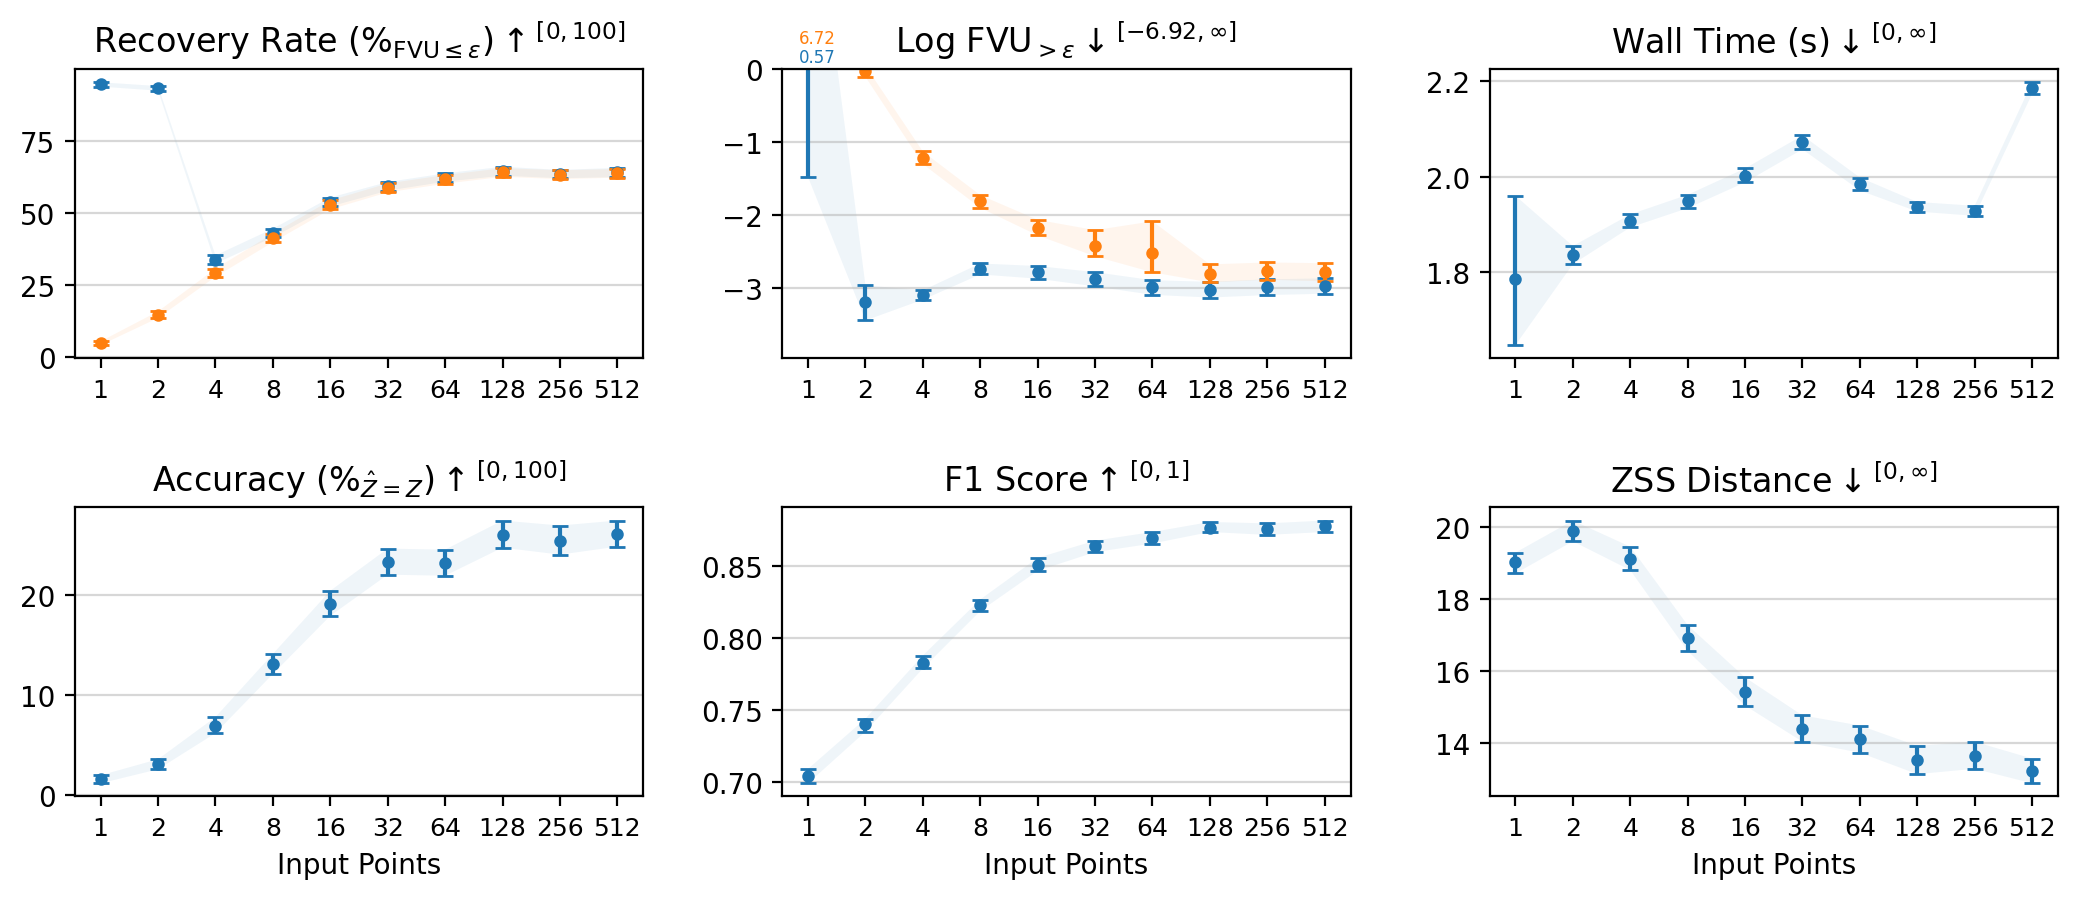

In [171]:
show_metric_list = ['FVU-eps_accuracy', 'log_fvu_not_epsilon', 'wall_time', 'accuracy_best_beam', 'f1_score_best_beam', 'tree_edit_distance_best_beam']
objective_list = ['max', 'min', 'min', 'max', 'max', 'min']
y_label_list = ['Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)', 'Log FVU$_{>\\epsilon}$', 'Wall Time (s)', 'Accuracy ($\%_{\hat{Z} = Z}$)', 'F1 Score', 'ZSS Distance']
bounds_list = [(0, 100), (np.log10(np.finfo(np.float32).eps).round(2), None), (0, None), (0, 100), (0, 1), (0, None)]
sub_metric_list = ['mean', 'mean', 'mean', 'mean', 'mean', 'mean']
factor_list = [100, 1, 1, 100, 1, 1]
yscale_list = ['linear', 'linear', 'linear', 'linear', 'linear', 'linear']
# ylim_list = [(0, 100), (np.log10(np.finfo(np.float32).eps), None), (0, None), (0, 1), (0, None)]
ylim_list = [None, (None, 0), None, None, None, None]

x = [configs[model]['n_support'] for model in MODELS]

COLS = min(3, len(show_metric_list))
ROWS = np.ceil(len(show_metric_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3.5, ROWS * 2.3), dpi=200)

for i, (show_metric, sub_metric, ax, y_label, factor, ylim, objective, bounds, yscale) in enumerate(
    zip(show_metric_list, sub_metric_list, axes.flatten(), y_label_list, factor_list, ylim_list, objective_list, bounds_list, yscale_list)):

    show_metrics = [show_metric]
    if f'{show_metric}_val' in total_summary_tables[sub_metric]['median'].T.index:
        show_metrics.append(f'{show_metric}_val')

    for k, (s, label) in enumerate(zip(show_metrics, ['Fit', 'Validation'])):
        y = total_summary_tables[sub_metric]['median'].T.loc[s] * factor
        y_lower = total_summary_tables[sub_metric]['lower'].T.loc[s] * factor
        y_upper = total_summary_tables[sub_metric]['upper'].T.loc[s] * factor

        ax.errorbar(x, y, yerr=[y - y_lower, y_upper - y], fmt='.', markersize=7, capsize=3)
        sorted_indices = np.argsort(x)
        ax.fill_between(np.array(x)[sorted_indices], np.array(y_lower)[sorted_indices], np.array(y_upper)[sorted_indices], alpha=0.07)

    ax.set_xscale('log', base=2)
    arrow = ('$\\uparrow' if objective == 'max' else '$\\downarrow') + '^{[' + str(bounds[0]) + ', ' + (str(bounds[1]) if bounds[1] is not None else '\\infty') + ']}$'
    ax.set_title(y_label + f'{arrow}')
    ax.set_xticks(x)
    ax.set_xticklabels(x, fontsize=9)

    if i // COLS == ROWS - 1:
        ax.set_xlabel('Input Points')
    # ax.set_xlabel('Beam Width')
    ax.grid(alpha=0.5, axis='y', which='both')

    ax.set_yscale(yscale)

    # if i == 2:
    #     ax.set_yticks(np.linspace(0, 1, 11).tolist())
    #     ax.set_yticklabels([f'A' for i in range(11)])

    ax.set_ylim(ylim)

    if i == 1:
        # Annotate the first data point above the axis
        annotation = total_summary_tables[sub_metric]["median"].T.loc[show_metrics[0]]['analysis_points_v7.0/v7.0_1-points']
        ax.annotate(f'{annotation:.2f}', xy=(1, 0), xytext=(10, 1), textcoords='offset points', ha='right', va='bottom', color='tab:blue', fontsize=6)
        
        annotation = total_summary_tables[sub_metric]["median"].T.loc[show_metrics[1]]['analysis_points_v7.0/v7.0_1-points']
        ax.annotate(f'{annotation:.2f}', xy=(1, 0), xytext=(10, 8), textcoords='offset points', ha='right', va='bottom', color='tab:orange', fontsize=6)

for ax in axes.flatten()[len(show_metric_list):]:
    ax.axis('off')

fig.tight_layout(w_pad=2, h_pad=2)

plt.savefig(get_path('results', 'analysis_points', create=True, filename='analysis_points_errorbars.svg'))

In [48]:
sorted_models = sorted(configs, key=lambda x: configs[x]['n_support'])
sorted_models

['analysis_points_v7.0/v7.0_1-points',
 'analysis_points_v7.0/v7.0_2-points',
 'analysis_points_v7.0/v7.0_4-points',
 'analysis_points_v7.0/v7.0_8-points',
 'analysis_points_v7.0/v7.0_16-points',
 'analysis_points_v7.0/v7.0_32-points',
 'analysis_points_v7.0/v7.0_64-points',
 'analysis_points_v7.0/v7.0_128-points',
 'analysis_points_v7.0/v7.0_256-points',
 'analysis_points_v7.0/v7.0_512-points']

In [64]:
double_accuracy_data = {
    'fit': {
        'y': total_summary_tables['mean']['median'].T.loc['FVU-eps_accuracy'][sorted_models].values,
        'y_lower': total_summary_tables['mean']['lower'].T.loc['FVU-eps_accuracy'][sorted_models].values,
        'y_upper': total_summary_tables['mean']['upper'].T.loc['FVU-eps_accuracy'][sorted_models].values,
        'x': total_summary_tables['mean']['median'].T.loc['accuracy_best_beam'][sorted_models].values,
        'x_lower': total_summary_tables['mean']['lower'].T.loc['accuracy_best_beam'][sorted_models].values,
        'x_upper': total_summary_tables['mean']['upper'].T.loc['accuracy_best_beam'][sorted_models].values
    },
    'val': {
        'y': total_summary_tables['mean']['median'].T.loc['FVU-eps_accuracy_val'][sorted_models].values,
        'y_lower': total_summary_tables['mean']['lower'].T.loc['FVU-eps_accuracy_val'][sorted_models].values,
        'y_upper': total_summary_tables['mean']['upper'].T.loc['FVU-eps_accuracy_val'][sorted_models].values,
        'x': total_summary_tables['mean']['median'].T.loc['accuracy_best_beam'][sorted_models].values,
        'x_lower': total_summary_tables['mean']['lower'].T.loc['accuracy_best_beam'][sorted_models].values,
        'x_upper': total_summary_tables['mean']['upper'].T.loc['accuracy_best_beam'][sorted_models].values
    } 
}

In [65]:
import numpy as np
from scipy import odr

def linear_func(B, x):
    return B[0] * x + B[1]

discard_first_n = 2

In [66]:
double_accuracy_fits = {}

for key, data in double_accuracy_data.items():
    x = data['x']
    y = data['y']
    x_upper = data['x_upper']
    x_lower = data['x_lower']
    y_upper = data['y_upper']
    y_lower = data['y_lower']

    # The upper and lower bounds are the 97.5th and 2.5th percentiles
    # Comvert to standard deviation to use as weights
    ninety_five_in_std = 1.96
    x_upper_std = x + (x_upper - x) / ninety_five_in_std
    x_lower_std = x - (x - x_lower) / ninety_five_in_std

    y_upper_std = y + (y_upper - y) / ninety_five_in_std
    y_lower_std = y - (y - y_lower) / ninety_five_in_std

    data = odr.Data(x[discard_first_n:], y[discard_first_n:], wd=1/(x_upper_std[discard_first_n:] - x_lower_std[discard_first_n:]), we=1/(y_upper_std[discard_first_n:] - y_lower_std[discard_first_n:]))
    model = odr.Model(linear_func)
    odr_fit = odr.ODR(data, model, beta0=[1., 0.])
    output = odr_fit.run()

    double_accuracy_fits[key] = output.beta

    print(output.beta)

    # R2
    print(f'R2: {output.res_var}')

    double_accuracy_fits[key] = {
        'slope': output.beta[0],
        'intercept': output.beta[1],
        'slope_err': output.sd_beta[0],
        'intercept_err': output.sd_beta[1],
        'r2': output.res_var
    }

[1.62914636 0.22343001]
R2: 0.0023082863820162074
[1.83194684 0.17057926]
R2: 0.0022090108190832318


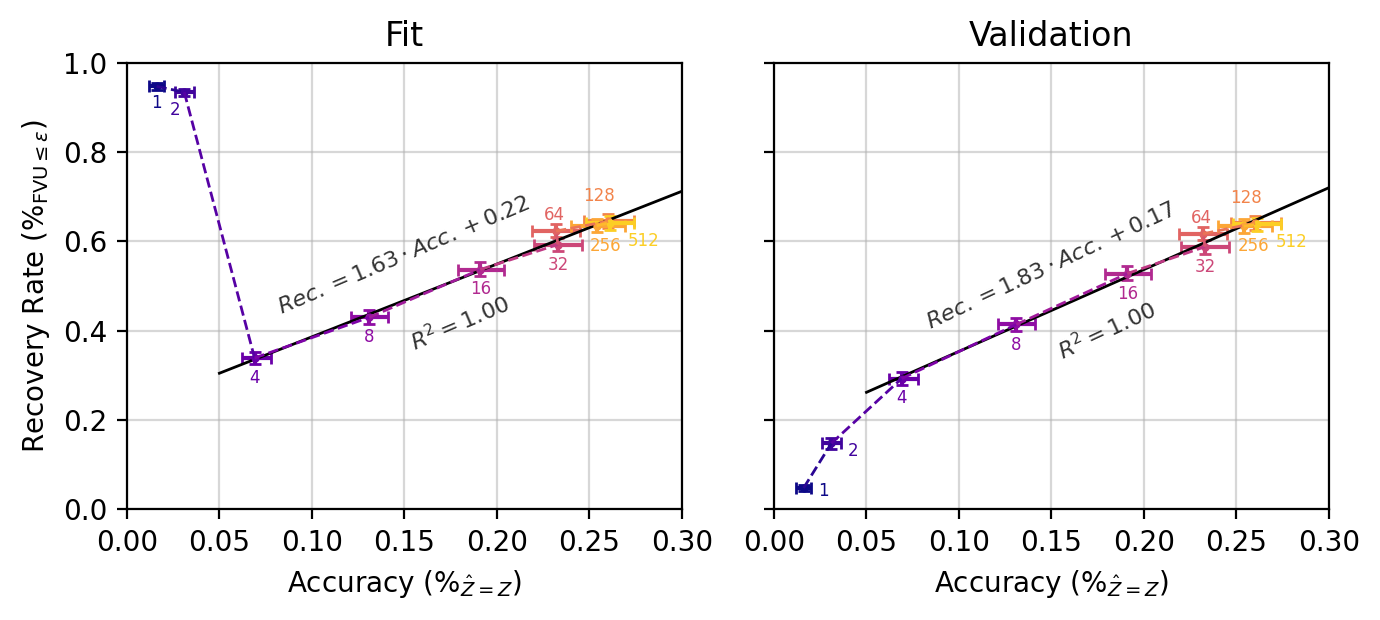

In [138]:
# Plot the zss distance vs the recovery rate
fig, axes = plt.subplots(1, 2, figsize=(7, 3.2), dpi=200, sharey=True)

for m, (ax, (data_k, data_v), fit, title, angle) in enumerate(zip(axes, double_accuracy_data.items(), double_accuracy_fits.values(), ['Fit', 'Validation'], [23, 25])):
    x = data_v['x']
    y = data_v['y']
    x_upper = data_v['x_upper']
    x_lower = data_v['x_lower']
    y_upper = data_v['y_upper']
    y_lower = data_v['y_lower']
    for i in range(len(x)):
        ax.errorbar(x[i], y[i], xerr=[[x[i] - x_lower[i]], [x_upper[i] - x[i]]], yerr=[[y[i] - y_lower[i]], [y_upper[i] - y[i]]], fmt='.', markersize=4, capsize=2, color=plt.get_cmap('plasma')(i / len(x)))
        # Plot a line between each point and its previous point
        if i > 0:
            ax.plot([x[i-1], x[i]], [y[i-1], y[i]], color=plt.get_cmap('plasma')((i - 0.5) / len(x)), linestyle='--', linewidth=1, zorder=3)

        if m == 0:
            if configs[sorted_models[i]]['n_support'] == 2:
                ax.annotate(configs[sorted_models[i]]['n_support'], (x[i] -0.005, y_lower[i] - 0.01), fontsize=6, ha='center', va='top', zorder=4, color=plt.get_cmap('plasma')(i / len(x)))
            elif configs[sorted_models[i]]['n_support'] == 64:
                ax.annotate(configs[sorted_models[i]]['n_support'], (x[i] -0.001, y_upper[i]), fontsize=6, ha='center', va='bottom', zorder=4, color=plt.get_cmap('plasma')(i / len(x)))
            elif configs[sorted_models[i]]['n_support'] == 128:
                ax.annotate(configs[sorted_models[i]]['n_support'], (x[i] -0.005, y_upper[i] + 0.02), fontsize=6, ha='center', va='bottom', zorder=4, color=plt.get_cmap('plasma')(i / len(x)))
            elif configs[sorted_models[i]]['n_support'] == 256:
                ax.annotate(configs[sorted_models[i]]['n_support'], (x[i] +0.005, y_upper[i] - 0.04), fontsize=6, ha='center', va='top', zorder=4, color=plt.get_cmap('plasma')(i / len(x)))
            elif configs[sorted_models[i]]['n_support'] == 512:
                ax.annotate(configs[sorted_models[i]]['n_support'], (x[i] +0.01, y_upper[i] - 0.035), fontsize=6, ha='left', va='top', zorder=4, color=plt.get_cmap('plasma')(i / len(x)))
            else:
                ax.annotate(configs[sorted_models[i]]['n_support'], (x[i], y_lower[i] - 0.01), fontsize=6, ha='center', va='top', zorder=4, color=plt.get_cmap('plasma')(i / len(x)))
        else:
            if configs[sorted_models[i]]['n_support'] == 1:
                ax.annotate(configs[sorted_models[i]]['n_support'], (x[i] +0.008, y_lower[i]), fontsize=6, ha='left', va='center', zorder=4, color=plt.get_cmap('plasma')(i / len(x)))
            elif configs[sorted_models[i]]['n_support'] == 2:
                ax.annotate(configs[sorted_models[i]]['n_support'], (x[i] +0.012, y_lower[i] - 0.005), fontsize=6, ha='center', va='center', zorder=4, color=plt.get_cmap('plasma')(i / len(x)))
            elif configs[sorted_models[i]]['n_support'] == 64:
                ax.annotate(configs[sorted_models[i]]['n_support'], (x[i] -0.001, y_upper[i]), fontsize=6, ha='center', va='bottom', zorder=4, color=plt.get_cmap('plasma')(i / len(x)))
            elif configs[sorted_models[i]]['n_support'] == 128:
                ax.annotate(configs[sorted_models[i]]['n_support'], (x[i] -0.005, y_upper[i] + 0.02), fontsize=6, ha='center', va='bottom', zorder=4, color=plt.get_cmap('plasma')(i / len(x)))
            elif configs[sorted_models[i]]['n_support'] == 256:
                ax.annotate(configs[sorted_models[i]]['n_support'], (x[i] +0.005, y_upper[i] - 0.04), fontsize=6, ha='center', va='top', zorder=4, color=plt.get_cmap('plasma')(i / len(x)))
            elif configs[sorted_models[i]]['n_support'] == 512:
                ax.annotate(configs[sorted_models[i]]['n_support'], (x[i] +0.01, y_upper[i] - 0.035), fontsize=6, ha='left', va='top', zorder=4, color=plt.get_cmap('plasma')(i / len(x)))
            else:
                ax.annotate(configs[sorted_models[i]]['n_support'], (x[i], y_lower[i] - 0.01), fontsize=6, ha='center', va='top', zorder=4, color=plt.get_cmap('plasma')(i / len(x)))


    if m == 0:
        ax.set_ylabel('Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)')
    ax.set_xlabel('Accuracy ($\%_{\hat{Z} = Z}$)')
    ax.grid(alpha=0.5, axis='both', which='both', zorder=0)

    x_linspace = np.linspace(0.05, 0.3, 10)
    y_linspace = x_linspace * fit['slope'] + fit['intercept']
    ax.plot(x_linspace, y_linspace, color='k', linestyle='-', linewidth=1)

    ylim = (0, 1)
    xlim = (0, 0.3)

    anchor1 = 0.15
    anchor2 = 0.18

    ax.annotate(f'$Rec. = {fit["slope"]:.2f} \cdot Acc. + {fit["intercept"]:.2f}$', (anchor1, anchor1 * fit['slope'] + fit['intercept'] + 0.1), fontsize=8, ha='center', va='center', rotation=angle, alpha=0.8)
    ax.annotate(f'$R^2 = {1 - fit["r2"]:.2f}$', (anchor2, anchor2 * fit['slope'] + fit['intercept'] - 0.1), fontsize=8, ha='center', va='center', rotation=angle, alpha=0.8)

    ax.set_title(title)

    ax.set_ylim(ylim)
    ax.set_xlim(xlim)

    fig.tight_layout()

    plt.savefig(get_path('results', 'analysis_points', create=True, filename='analysis_points_identifiability_fit.svg'))

Hypothesis:
With less input points, the symbolic accuracy will decrease, as the fewer points there are, the more functions can fit the data.
While symbolic accuracy decreases due to the identifiability problem, the numeric accuracy may stay the same or increase if the model can still fit the GT function, or any other function that fits the data.

Observation:
The symbolic accuracy decreases with fewer input points, as expected.
However, the numeric accuracy also decreases with fewer input points.

Why?
- traiing support uniform from 16 to 512
- investigate examples (what changes with same equation and decreasing number of points?)

In [52]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary_lengths = {length: {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()} for length in range(32)}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 100

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data_lengths = {length: pd.concat([df[df['length_target'] == length] for test_set, df in model_dfs.items() if test_set in aggregate_sets]) for length in range(32)}

    for length in tqdm(range(32)):
        for column in compare_columns:
            if column in aggregated_data_lengths[length].columns:
                data = aggregated_data_lengths[length][column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                total_summary_lengths[length][model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary_lengths[length][model][column].keys()

  0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_5253/3880369273.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(x)[np.isfinite(x)])
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1649: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  9%|▉         | 3/32 [00:00<00:06,  4.28it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
 22%|██▏       | 7/32 [00:01<00:07,  3.29it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4623: RuntimeWarning: invalid value encountered 

In [53]:
total_summary_tables_length = {
    length: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    column: total_summary_lengths[length][model][column][metric][k]
                    for column in compare_columns}
                    for model in total_summary.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for length in range(32)}

In [54]:
from matplotlib.colors import LogNorm

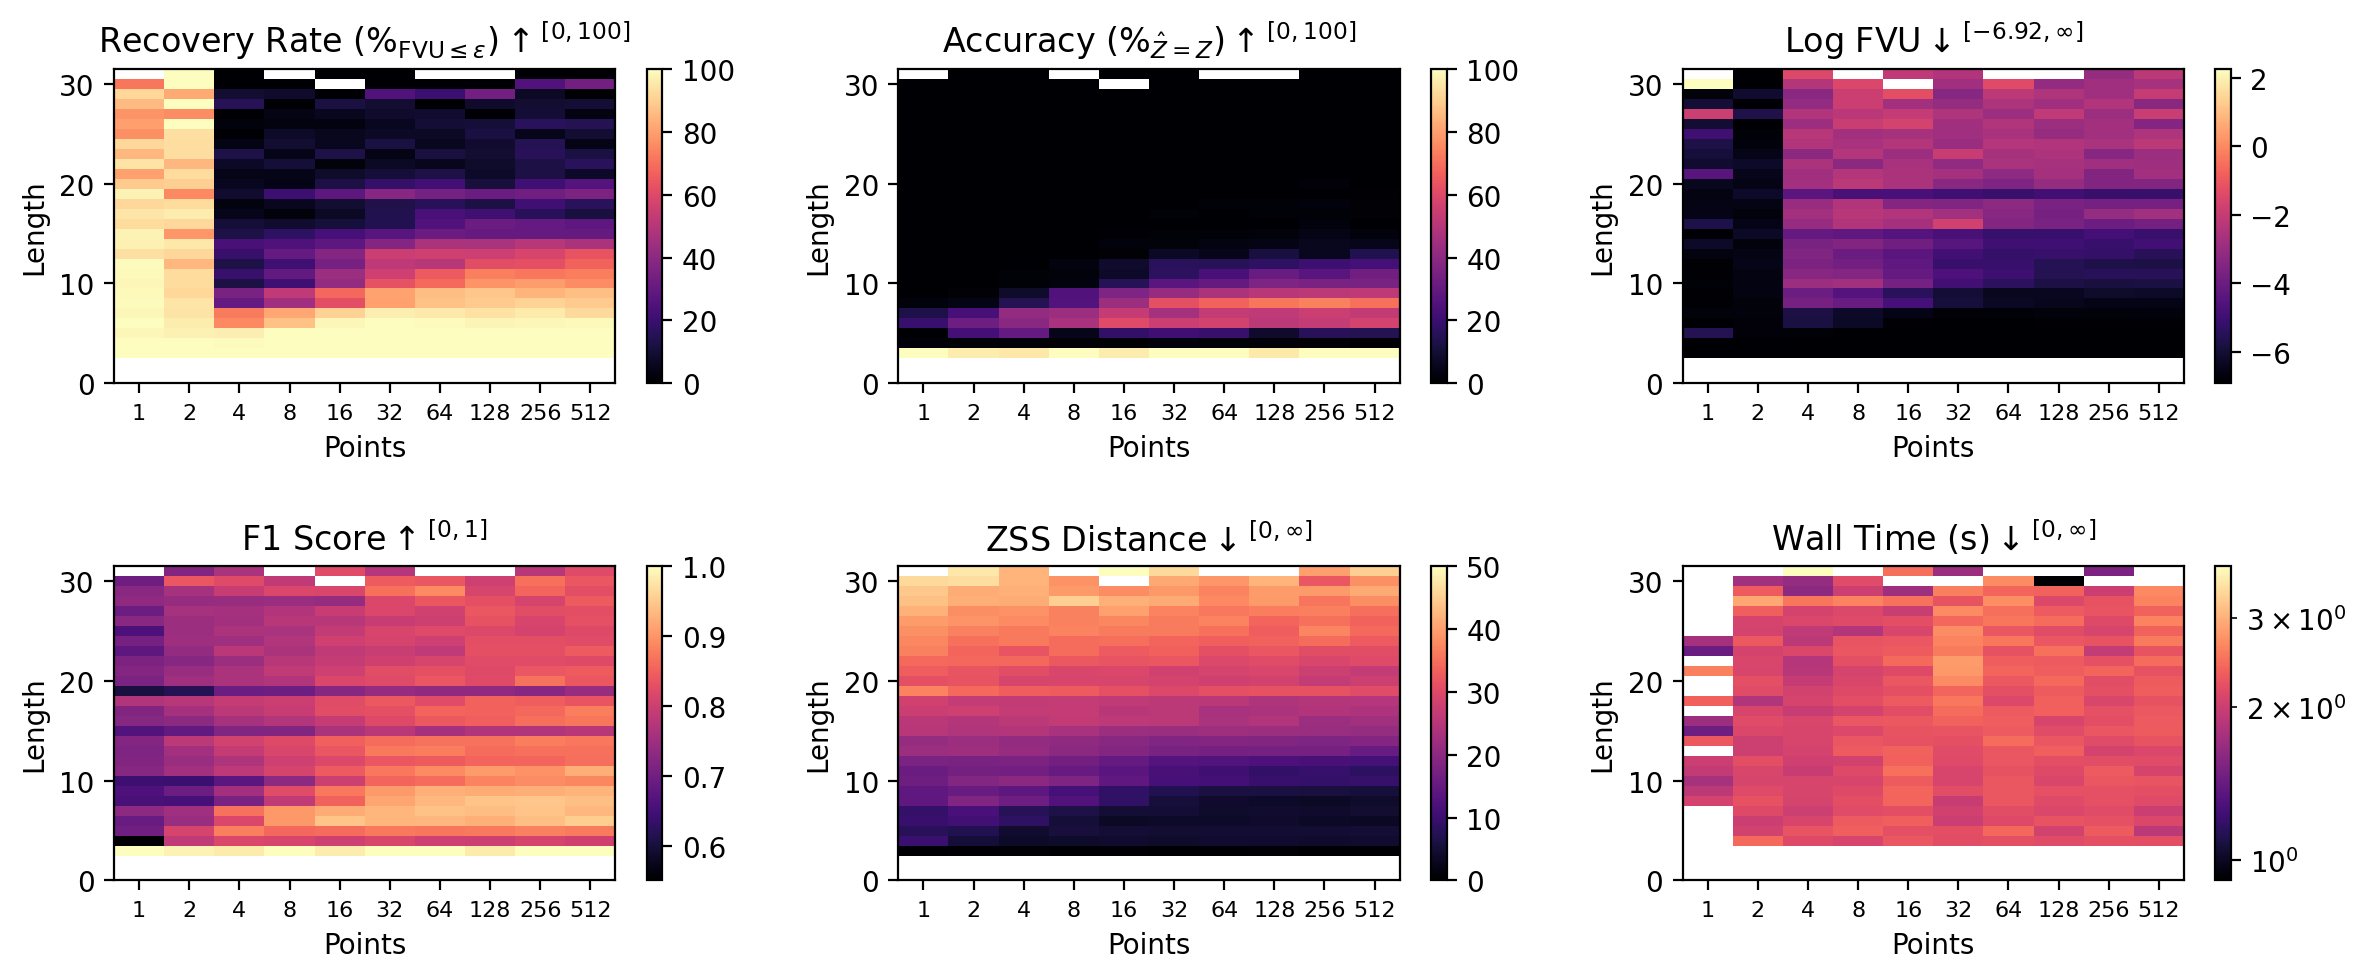

In [55]:
show_metric_list = ['FVU-eps_accuracy', 'accuracy_best_beam', 'log_fvu', 'f1_score_best_beam', 'tree_edit_distance_best_beam', 'wall_time']
objective_list = ['max', 'max', 'min', 'max', 'min', 'min']
y_label_list = ['Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)', 'Accuracy ($\%_{\hat{Z} = Z}$)', 'Log FVU', 'F1 Score', 'ZSS Distance', 'Wall Time (s)']
bounds_list = [(0, 100), (0, 100), (np.log10(np.finfo(np.float32).eps).round(2), None), (0, 1), (0, None), (0, None)]
sub_metric_list = ['mean', 'mean', 'mean', 'mean', 'mean', 'mean']
factor_list = [100, 100, 1, 1, 1, 1]
log_norm_list = [False, False, False, False, False, True]
# ylim_list = [(0, 100), (np.log10(np.finfo(np.float32).eps), None), (0, None), (0, 1), (0, None)]
ylim_list = [(0, 31.5)] * len(show_metric_list)

x = np.array([configs[model]['n_support'] for model in MODELS])
sorted_indices = np.argsort(x)

COLS = min(3, len(show_metric_list))
ROWS = np.ceil(len(show_metric_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 4, ROWS * 2.5), dpi=200)

for i, (show_metric, sub_metric, ax, y_label, factor, ylim, log_norm, bounds, objective) in enumerate(
    zip(show_metric_list, sub_metric_list, axes.flatten(), y_label_list, factor_list, ylim_list, log_norm_list, bounds_list, objective_list)):
    y = np.array([s[sub_metric]['median'].T.loc[show_metric] for s in total_summary_tables_length.values()]) * factor

    mesh = np.meshgrid(np.log2(x[sorted_indices]), np.arange(32))
    colormesh = ax.pcolormesh(mesh[0], mesh[1], y[:, sorted_indices], shading='auto', cmap='magma', norm=LogNorm() if log_norm else None, linewidth=0, rasterized=True)
    # colormesh.set_edgecolor('face')


    ax.set_xticks(np.log2(x))
    ax.set_xticklabels(x, fontsize=8)

    ax.set_ylabel('Length')
    ax.set_xlabel('Points')
    arrow = ('$\\uparrow' if objective == 'max' else '$\\downarrow') + '^{[' + str(bounds[0]) + ', ' + (str(bounds[1]) if bounds[1] is not None else '\\infty') + ']}$'
    ax.set_title(y_label + f'{arrow}')
    
    # Add a little colorbar to each plot
    cb = plt.colorbar(colormesh, ax=ax)

    ax.set_ylim(ylim)

# hist_x = np.arange(32)
# hist_y = [len(aggregated_data_lengths[length]) for length in range(32)]

# hist_plot_x = np.empty(2 * len(hist_x))
# hist_plot_x[0::2] = hist_x - 0.5
# hist_plot_x[1::2] = hist_x + 0.5
# hist_plot_y = np.empty(2 * len(hist_y))
# hist_plot_y[0::2] = hist_y
# hist_plot_y[1::2] = hist_y

# axes.flatten()[-1].fill_betweenx(hist_plot_x, hist_plot_y, color='k', alpha=0.2)
# axes.flatten()[-1].set_xlim(0, None)
# axes.flatten()[-1].set_xlabel('Number of Test Equations')
# axes.flatten()[-1].set_ylabel('Length')
# axes.flatten()[-1].grid(alpha=0.5)
# axes.flatten()[-1].set_ylim(0, 32)
# axes.flatten()[-1].set_title('Aggregated Test Set Distribution')

# Add a phantom colorbar
# cb = plt.colorbar(colormesh, ax=axes.flatten()[-1])
# Hide the colorbar
# cb.ax.set_visible(False)

fig.tight_layout(w_pad=2, h_pad=2)

plt.savefig(get_path('results', 'analysis_beams', create=True, filename='analysis_beams_length_heatmap.svg'))

# Examples

In [56]:
from flash_ansr.expressions.utils import num_to_constants, codify

In [57]:
space = ExpressionSpace.from_config(get_path('configs', 'v6.0', 'expression_space.yaml'))

In [58]:
results['analysis_points/v6.0_1-points']['feynman']['data']['input_ids'][0].tolist()

[1, 11, 30, 18, 8, 6, 11, 14, 31, 14, 32, 2]

In [59]:
results_per_equation = {}
for model, model_results in tqdm(results.items()):
    results_per_equation[model] = {}
    for test_set, test_set_results in model_results.items():
        results_per_equation[model][test_set] = {}
        for i in range(len(test_set_results['data']['input_ids'])):
            equation = tuple(test_set_results['data']['input_ids'][i].tolist())
            if equation not in results_per_equation[model][test_set]:
                results_per_equation[model][test_set][equation] = []
            results_per_equation[model][test_set][equation].append({k: test_set_results['data'][k][i] for k in test_set_results['data'].keys()})

100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


In [60]:
for eq, eq_results in results_per_equation['analysis_points/v6.0_32-points']['feynman'].items():
    print(eq, len(eq_results))

(1, 14, 31, 2) 20
(1, 10, 30, 11, 31, 10, 6, 10, 6, 32, 2) 21
(1, 11, 6, 10, 31, 10, 32, 8, 30, 6, 2) 23
(1, 11, 28, 9, 11, 14, 30, 6, 6, 2) 20
(1, 11, 7, 6, 11, 30, 31, 10, 32, 18, 8, 6, 11, 14, 30, 14, 31, 2) 23
(1, 10, 30, 10, 31, 14, 32, 2) 27
(1, 10, 30, 11, 31, 18, 8, 6, 11, 14, 31, 14, 32, 2) 25
(1, 25, 10, 30, 22, 31, 2) 15
(1, 10, 30, 11, 31, 6, 2) 27
(1, 11, 30, 18, 8, 6, 11, 14, 31, 14, 32, 2) 23
(1, 11, 30, 10, 6, 10, 6, 14, 31, 2) 18
(1, 13, 10, 30, 14, 31, 2) 25
(1, 10, 30, 31, 2) 24
(1, 18, 8, 11, 14, 30, 14, 31, 11, 6, 14, 32, 2) 23
(1, 10, 30, 11, 31, 10, 6, 10, 6, 10, 32, 15, 31, 2) 26
(1, 10, 30, 10, 31, 22, 32, 2) 28
(1, 10, 30, 7, 6, 10, 31, 23, 32, 2) 21
(1, 11, 28, 9, 11, 14, 11, 8, 30, 31, 32, 6, 10, 6, 32, 2) 32
(1, 25, 11, 30, 10, 31, 32, 2) 17
(1, 11, 6, 7, 11, 6, 30, 11, 31, 32, 2) 36
(1, 9, 10, 30, 10, 31, 23, 32, 2) 18
(1, 10, 6, 14, 31, 2) 24
(1, 11, 30, 10, 6, 7, 6, 31, 2) 28
(1, 10, 30, 11, 14, 31, 6, 2) 24
(1, 10, 30, 14, 31, 2) 25
(1, 18, 10, 30, 11, 

In [61]:
eq = list(results_per_equation[f'analysis_points/v6.0_32-points']['soose_nc'].keys())[109]
print(space.tokenizer.decode(eq, special_tokens='<num>'))

n_points_list = sorted([configs[model]['n_support'] for model in MODELS])
print(n_points_list)

fvus_per_points = [[res['log_fvu'] for res in results_per_equation[f'analysis_points/v6.0_{n_points}-points']['soose_nc'][eq]] for n_points in n_points_list if eq in results_per_equation[f'analysis_points/v6.0_{n_points}-points']['soose_nc']]
for n_points, fvus in zip(n_points_list, fvus_per_points):
    print(n_points, np.median(fvus).round(2), np.percentile(fvus, 2.5).round(2), np.percentile(fvus, 97.5).round(2))

['cos', 'pow5', '+', 'x1', '-', '/', '<num>', 'x2', 'x2']
[1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
1 -6.92 -6.92 -6.92
2 -6.92 -6.92 -6.92
4 -2.13 -2.36 -1.54
8 -0.91 -1.13 -0.61
16 -0.2 -0.2 -0.2
32 -0.05 -0.13 0.09
64 0.0 -0.01 0.08
128 -0.0 -0.41 0.11
256 0.18 -0.0 0.21
512 0.1 0.0 0.19


In [62]:
n_points = 32
for i in range(len(results_per_equation[f'analysis_points/v6.0_{n_points}-points']['soose_nc'][eq])):
    best_beam = int(results_per_equation[f'analysis_points/v6.0_{n_points}-points']['soose_nc'][eq][i]['best_beam'])
    print(space.tokenizer.decode(results_per_equation[f'analysis_points/v6.0_{n_points}-points']['soose_nc'][eq][i][f'free_beam_{best_beam}'], special_tokens='<num>'))

['cos', 'pow2', 'tan', '+', '<num>', '+', 'x1', 'x2']
['cos', 'pow5', '+', '<num>', '-', 'x1', 'x2']
['cos', 'pow3', 'tan', '+', 'x1', '-', 'x2', '<num>']
['cos', 'tan', '*', '<num>', '*', 'x1', '*', 'x2', '+', '<num>', 'x1']
['cos', '*', '<num>', '*', 'x1', 'pow4', '-', 'x1', 'x2']


In [63]:
import torch
from flash_ansr.expressions.utils import codify, num_to_constants

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [64]:
from flash_ansr import FlashANSR, FlashANSRTransformer

In [65]:
MODEL = 'v6.0'
CHECKPOINT = ''

In [66]:
nsr = FlashANSR(
    expression_space=ExpressionSpace.from_config(get_path('models', 'ansr-models', MODEL, CHECKPOINT, 'expression_space.yaml')),
    flash_ansr_transformer=FlashANSRTransformer.load(get_path('models', 'ansr-models', MODEL, CHECKPOINT))[1].to(device).eval(),
    beam_width=32,
    n_restarts=4,
    verbose=True,
    numeric_head=False
)

nsr.flash_ansr_transformer.to(device).eval();

In [67]:
demo_expressions = [
    ('x**2', None, (-5, 5)),
    ('sin(x)', None, (-5, 5)),
    ('sin(x * 1.3) * 1.2', (1.2, 1.2), (-10, 10)),
    ('-x + log(x + x**4)', None, (1, 5)),
    ('x1**2 + 2*x1 + 1', (2, 1), (1, 5)),
    ('exp(- x**2)', None, (-5, 5)),
    ('x**3 + 2*x**2 + 1', (2, 1), (-5, 5)),
    ('exp(- (x - 3.4)**2)', (3.4,), (-5, 5)),
    ('exp(- (x - 1.4)**2 / 4.3)', (1.4, 4.3), (-5, 5)),
    ('cos(3.3 * x) * exp(-x * 0.5)', (3.3, 0.5,), (0, 5)),
    ('1.2', (1.2,), (-5, 5)),
    ('sin(tan(x))', None, (-5, 5)),
    ('asin((sin(x1) / x1))', None, (-10, 10)),
]

expression, constants, xlim = demo_expressions[2]

prefix_expression = nsr.expression_space.parse_expression(expression, mask_numbers=True)
prefix_expression_w_num = nsr.expression_space.operators_to_realizations(prefix_expression)
prefix_expression_w_constants, constants_names = num_to_constants(prefix_expression_w_num)
code_string = nsr.expression_space.prefix_to_infix(prefix_expression_w_constants, realization=True)
code = codify(code_string, nsr.expression_space.variables + constants_names)

if constants is None:
    demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0)
else:
    demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0, *constants)

In [68]:
example_expression = ['*', 'sin', '*', 'x1', '<num>', '<num>']
constants = (1.26, 1.389)
example_xlim = (-10, 10)

x_full = np.random.uniform(*xlim, 32)
x_linspace = np.linspace(xlim[0] - 0.5, xlim[1] + 0.5, 1000)

In [69]:
prefix_expression_w_num = nsr.expression_space.operators_to_realizations(example_expression)
prefix_expression_w_constants, constants_names = num_to_constants(prefix_expression_w_num)
code_string = nsr.expression_space.prefix_to_infix(prefix_expression_w_constants, realization=True)
code = codify(code_string, nsr.expression_space.variables + constants_names)

if constants is None:
    demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0)
else:
    demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0, *constants)

y_full = demo_function(x_full)

if isinstance(y_full, float):
    y_full = np.full_like(x_full, y_full)

y_linspace = demo_function(x_linspace)

In [ ]:
# Iteratively remove one point at a time
indices_to_use = np.random.permutation(32)
y_pred_list = []
y_pred_linspace_list = []
expression_list = []
fvu_list = []

for i in tqdm(range(32)):
    x_tensor = torch.tensor(x_full[indices_to_use[i:]], dtype=torch.float32).unsqueeze(-1).to(device)
    y_tensor = torch.tensor(y_full[indices_to_use[i:]], dtype=torch.float32).unsqueeze(-1).to(device)

    nsr.fit(x_tensor, y_tensor)

    x_linspace_tensor = torch.tensor(x_linspace, dtype=torch.float32).unsqueeze(-1).to(device)
    x_linspace_tensor = torch.tensor(x_linspace, dtype=torch.float32).unsqueeze(-1).to(device)

    y_pred = nsr.predict(x_tensor.cpu())
    y_pred_linspace = nsr.predict(x_linspace_tensor.cpu())

    y_pred_list.append(y_pred)
    y_pred_linspace_list.append(y_pred_linspace)
    expression_list.append(nsr.get_expression())

    fvu = torch.sum((y_pred.flatten() - y_tensor.flatten().cpu())**2) / torch.std(y_tensor.flatten().cpu())**2
    fvu_list.append(fvu.item())

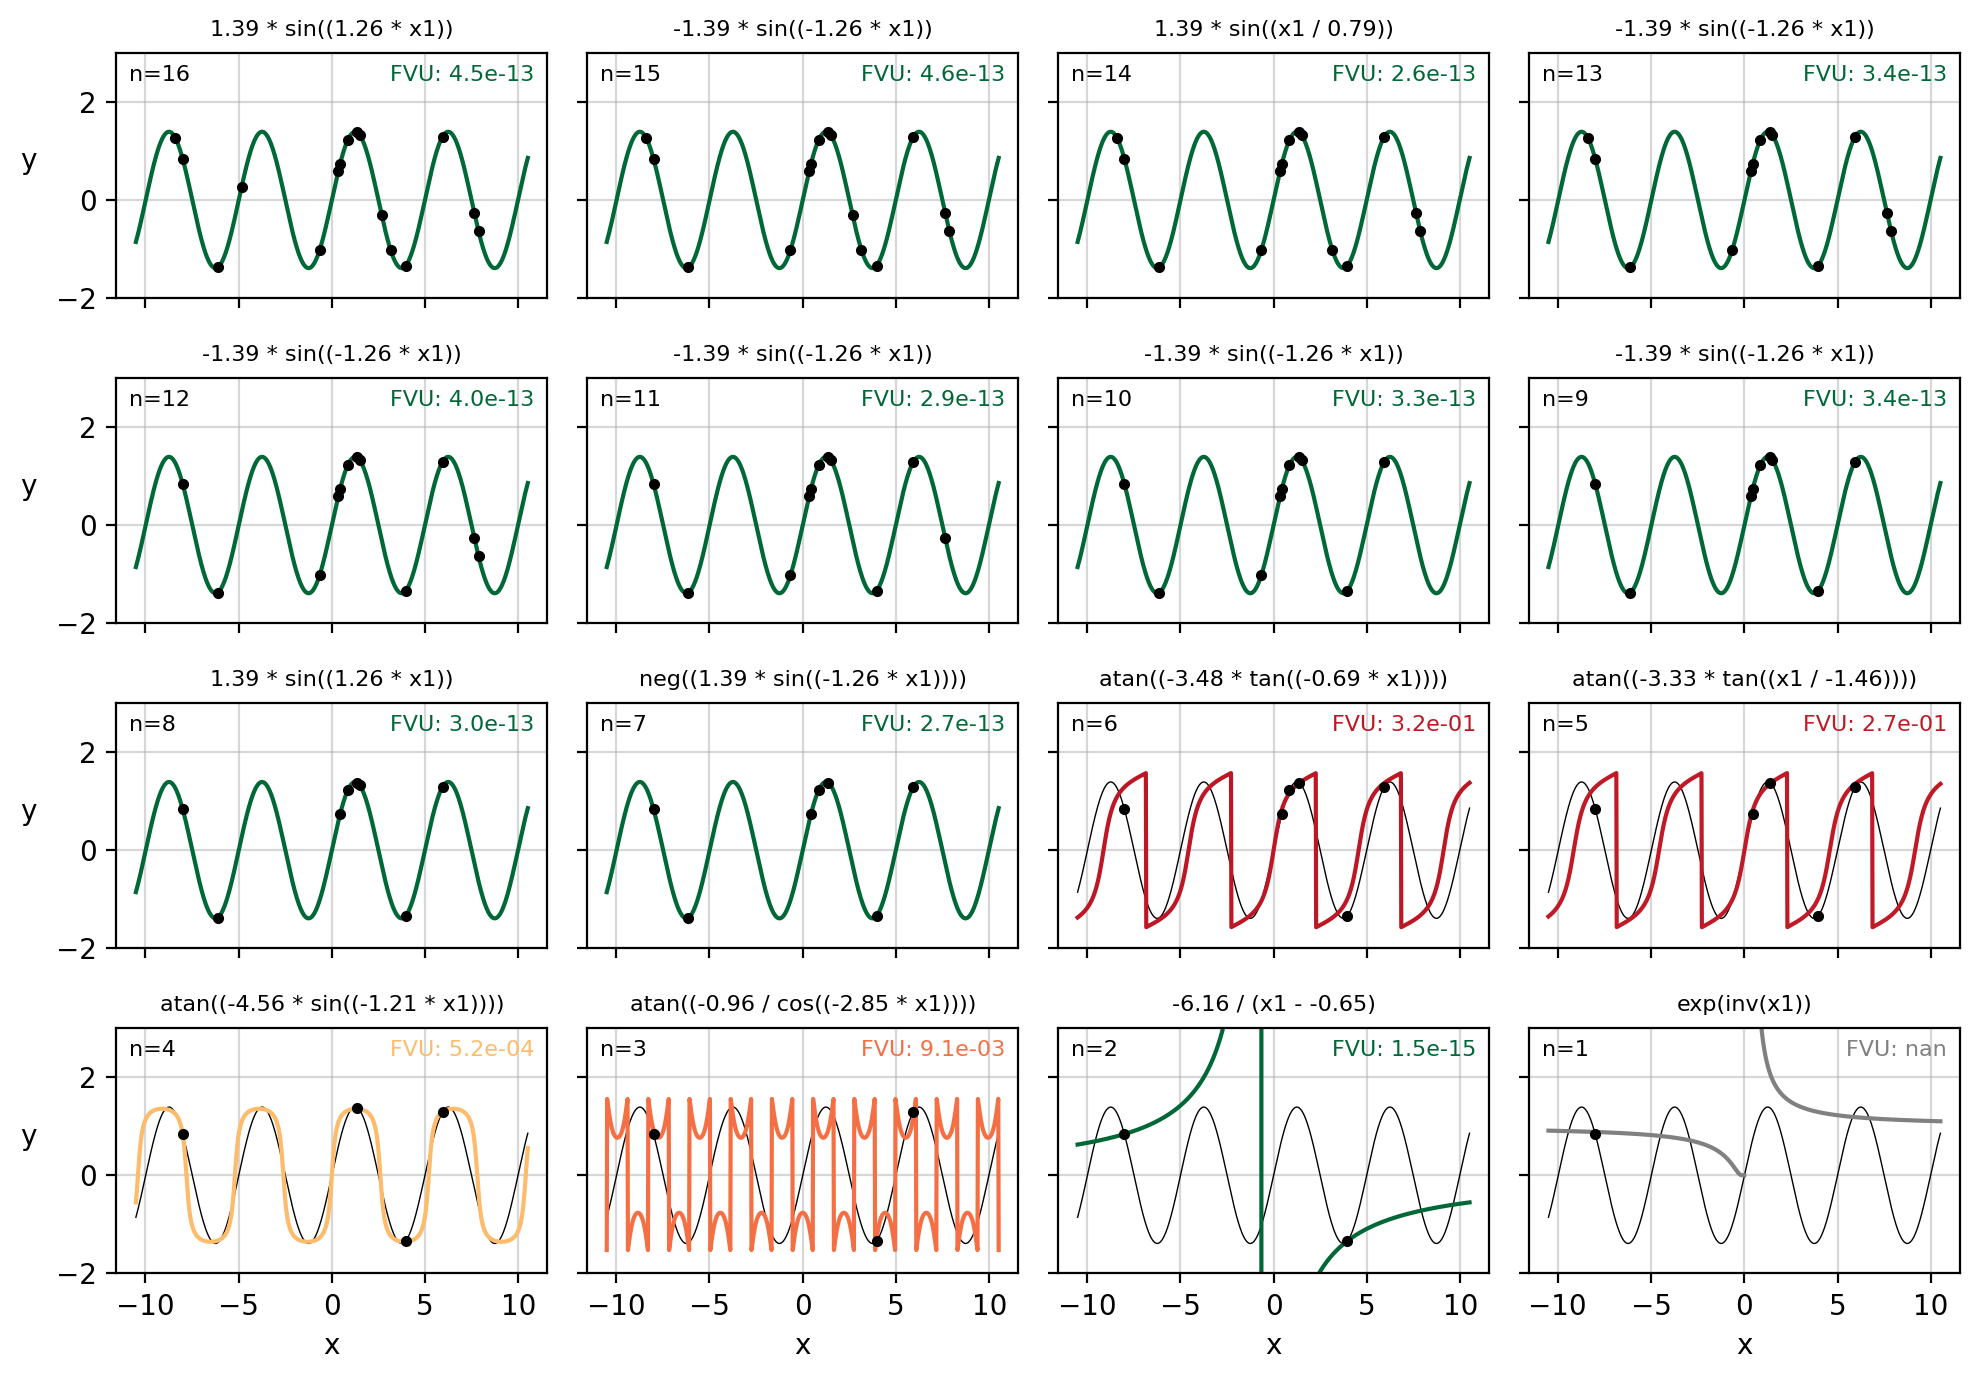

In [188]:
fig, axes = plt.subplots(4, 4, figsize=(10, 7), dpi=200, sharex=True, sharey=True)

for ax, i in zip(axes.flatten(), range(16, 32)):
    expression = expression_list[i]
    fvu = fvu_list[i]
    color = plt.get_cmap('RdYlGn')(-np.log10(fvu) / 10) if not np.isnan(fvu) else 'gray'
    ax.plot(x_linspace, y_linspace, label='True', color='k', linewidth=0.5)
    ax.plot(x_linspace, y_pred_linspace_list[i], label='Prediction', color=color)
    ax.plot(x_full[indices_to_use[i:]], y_full[indices_to_use[i:]], '.', label='Data', color='k')
    ax.annotate(f'FVU: {fvu:.1e}', (0.97, 0.95), xycoords='axes fraction', ha='right', va='top', fontsize=8, color=color)
    ax.annotate(f'n={len(indices_to_use[i:])}', (0.03, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=8)
    if expression.startswith('(') and expression.endswith(')'):
        expression = expression[1:-1]
    ax.set_title(expression, fontsize=8)
    ax.grid(alpha=0.5)

for ax in axes[-1]:
    ax.set_xlabel('x')
for ax in axes[:, 0]:
    ax.set_ylabel('y', rotation=0, labelpad=10)


ax.set_ylim(-2, 3)

fig.tight_layout()

plt.savefig(get_path('results', 'analysis_points', create=True, filename='analysis_points_sin_points.svg'))